## Project name: PY sales optimizer
## Step 4 - Clusters and Strategy

In [40]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.metrics import silhouette_score
import statsmodels.api
import statsmodels.formula.api as smf
from scipy import stats
from scipy.spatial.distance import cdist
import plotly.express as px
#from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.pipeline import make_pipeline

seed = 100

#df=pd.read_csv('Pakistan Largest Ecommerce Dataset.csv')
df=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Pakistan Largest Ecommerce Dataset.csv");

In [42]:
#Drop na
df.dropna(axis=0,how='all',inplace=True)
df.dropna(axis=1,how='all',inplace=True)
df.dropna(axis=0,how='any',inplace=True, subset=['Customer ID'])

In [43]:
# Further feature engeneering
df["BI Status"]=df["BI Status"].replace(to_replace=['#REF!'],value=["Net"])
df['BIstatus_num'] = df['BI Status']
df['BIstatus_num'] = df['BIstatus_num'].replace(['Net'], 1)
df['BIstatus_num'] = df['BIstatus_num'].replace(['Valid'], 0)
df['BIstatus_num'] = df['BIstatus_num'].replace(['Gross'], -1)

df['status_new'] = df['status']
df['status_new'] = df['status_new'].replace(['order_refunded', 'refund'],'refunded')
df['status_new'] = df['status_new'].replace(['complete', 'closed'],'completed')
df['status_new'] = df['status_new'].replace(['paid','received','cod',"exchange"],'processing')
df['status_new'] = df['status_new'].replace(['holded','pending_paypal','payment_review'],'pending')

In [44]:
df=df[df["price"]>0]
df=df[df["grand_total"]>0]

In [45]:
# Adjusted grand total and discount amount
df['discount_rate'] = (df['discount_amount']/(df['grand_total'] + df['discount_amount']) * 100).round(2)
df['grand_item']=df['price']*df["qty_ordered"]*(1-df['discount_rate']/100)

In [46]:
df=df[df["category_name_1"]!='\\N']

In [47]:
df=df.drop(["sales_commission_code"],axis=1)

In [48]:
df['payment_method'].replace(['Easypay_MA','easypay_voucher'],'Easypay',inplace=True)
df['payment_method'].replace(['jazzwallet','jazzvoucher'],'Jazz',inplace=True)
df['payment_method'].replace(['customercredit','ublcreditcard'],'Credit',inplace=True)
df['payment_method'].replace(['internetbanking'],'bankalfalah',inplace=True)

In [49]:
# New variable of special intrest: Lifetime
df['Working Date2'] = pd.to_datetime(df['Working Date'])
base = df['Working Date2'].max()
df['Date'] = df['Working Date2'].apply(lambda x: x.date())
df['Customer_Since_Date'] = df.groupby('Customer ID')['Date'].transform(min)
df['Lifetime'] = (base.date() - df['Customer_Since_Date']).astype('timedelta64[D]') + 1

In [50]:
# Delete remaining "na" 
df=df.dropna(axis=0,how="any")

In [51]:
df_full = df.copy()

## RFM-Score and "best" Baseline Model

In [52]:
#Only focus on positive/"promissing" transactions 
df=df[(df["status_new"]=="completed")|(df["status_new"]=="processing")]


In [14]:
print("Z score = (x-mean)/standard deviation = 3, gives 99.7% of the data points lie between +/- standard deviation. We use this statistics concept to remove outliers!")

Z score = (x-mean)/standard deviation = 3, gives 99.7% of the data points lie between +/- standard deviation. We use this statistics concept to remove outliers!


In [53]:
#Delete outliers in attributes relevant for RFM-score calculation

#Number of orders (for Frequency)
T1=df.groupby(["Customer ID"]).agg({"increment_id":"count"})
m1=T1["increment_id"].mean()
s1=T1["increment_id"].std()
A1=T1[T1["increment_id"]<=m1+3*s1]
a1=A1.index
lis=[]
for id in df["Customer ID"]:
  lis.append(id in a1)

df1=df.iloc[lis]


# price, qty_ordered, discount_rate (for Monetary)
zpmax=df["price"].mean()+3*df["price"].std()
zpmin=df["price"].mean()-3*df["price"].std()
data=df1[(df1["price"]>=zpmin) & (df1["price"]<=zpmax)]

zqmax=data["qty_ordered"].mean()+3*data["qty_ordered"].std()
zqmin=data["qty_ordered"].mean()-3*data["qty_ordered"].std()
data=data[(data["qty_ordered"]>=zqmin) & (data["qty_ordered"]<=zqmax)]

zdmax=data["discount_rate"].mean()+3*data["discount_rate"].std()
zdmin=data["discount_rate"].mean()-3*data["discount_rate"].std()
data=data[(data["discount_rate"]>=zdmin) & (data["discount_rate"]<=zdmax)]

In [54]:
# Calculate RFM-scores:

# Recency: Days since last purchase

data['Working Date'] = pd.to_datetime(data['Working Date'])
base = data['Working Date'].max()
data['Date'] = data['Working Date'].apply(lambda x: x.date())
data['Most_Recent_Purchase'] = data.groupby('Customer ID')['Date'].transform(max)
data['Recency'] = (base.date() - data['Most_Recent_Purchase']).astype('timedelta64[D]')

# Frequency: Total number of purchases
data['Frequency'] = data.groupby('Customer ID')['increment_id'].transform('nunique')

# Monetary: Total amount spend
data['Monetary'] = data.groupby('Customer ID')['grand_item'].transform('sum')

#RFM table
RFM_abs= data[['Customer ID', 'Recency', 'Frequency', 'Monetary']].drop_duplicates()
RFM_abs.head()

Customer ID  Recency  Frequency  Monetary
0           1.0    788.0          1    1950.0
7           6.0    788.0          1     170.0
10          9.0    788.0          1    5500.0
11         10.0    788.0          1     366.0
13         11.0    560.0          4     945.0

In [55]:
# Baseline Model 
RFM=RFM_abs.copy().drop(["Customer ID"],axis=1)
scaler=preprocessing.MinMaxScaler().fit(RFM)
RFM=scaler.transform(RFM)

In [56]:
range_n_cluster = [2,3,4,5,6,7,8,9,10,11,12]
ssd = []
distortions = []
for i in range_n_cluster:
    kmeans = KMeans(n_clusters = i, random_state=seed)
    kmeans.fit(RFM)
    ssd.append(kmeans.inertia_)
    distortions.append(sum(np.min(cdist(RFM, kmeans.cluster_centers_, 'euclidean'), axis=1)) / np.size(RFM, axis = 0))

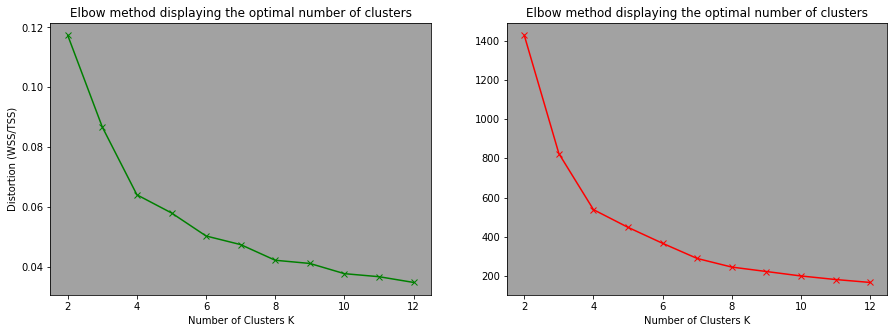

In [57]:
# Plotting the distortion as a function of the number of clusters
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(range_n_cluster, distortions, 'gx-')
plt.xlabel('Number of Clusters K')
plt.ylabel('Distortion (WSS/TSS)')
plt.title('Elbow method displaying the optimal number of clusters');

plt.subplot(1,2,2)
plt.plot(range_n_cluster, ssd, 'rx-')
plt.xlabel('Number of Clusters K')
plt.title('Elbow method displaying the optimal number of clusters');

In [58]:
kmeans=KMeans(n_clusters=4, random_state = seed)
kmeans.fit(RFM)
silhouette_score(RFM,kmeans.labels_,metric="sqeuclidean")

0.6743543307993832

In [59]:
RFM_res = RFM_abs.copy()
RFM_res['Cluster1'] = kmeans.labels_
RFM_res.head()

Customer ID  Recency  Frequency  Monetary  Cluster1
0           1.0    788.0          1    1950.0         0
7           6.0    788.0          1     170.0         0
10          9.0    788.0          1    5500.0         0
11         10.0    788.0          1     366.0         0
13         11.0    560.0          4     945.0         2

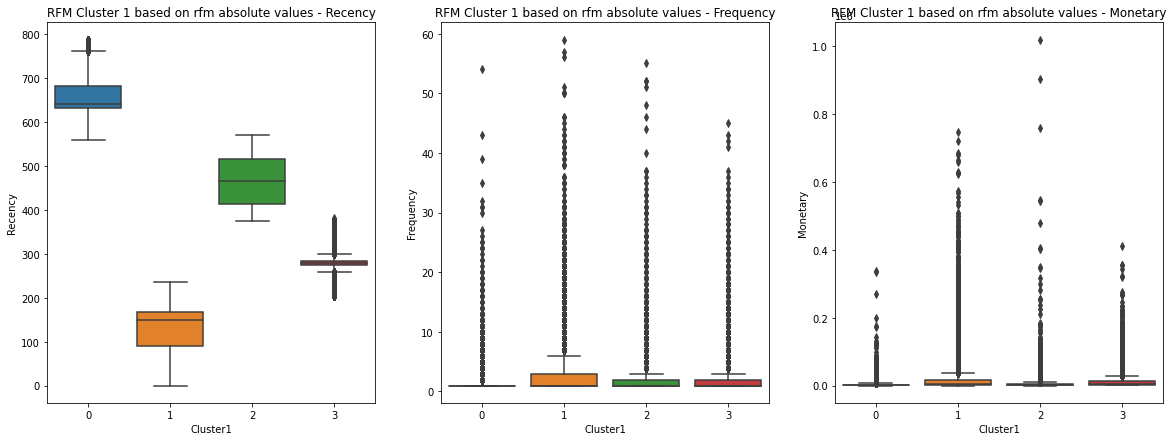

In [22]:
# Model interpretation

plt.figure(figsize=(20,7))
plt.subplot(1,3,1)
sns.boxplot(x = 'Cluster1', y='Recency', data=RFM_res)

plt.ylabel('Recency')
plt.title('RFM Cluster 1 based on rfm absolute values - Recency')

plt.subplot(1,3,2)
sns.boxplot(x = 'Cluster1', y='Frequency', data=RFM_res)

plt.ylabel('Frequency')
plt.title('RFM Cluster 1 based on rfm absolute values - Frequency')

plt.subplot(1,3,3)
sns.boxplot(x = 'Cluster1', y='Monetary', data=RFM_res)

plt.ylabel('Monetary')
plt.title('RFM Cluster 1 based on rfm absolute values - Monetary');


In [23]:
import plotly.express as px

RFMp=RFM_res.drop(["Cluster1"],axis=1)
fig = px.scatter_3d(RFMp, x="Frequency", y="Monetary", z="Recency",labels=RFM_res["Cluster1"], color=RFM_res["Cluster1"])

fig = fig.update_traces(marker=dict(size=2,
                              line=dict(width=2,
                                        color=RFM_res["Cluster1"])),
                  selector=dict(mode='markers'))

fig.layout.showlegend = True
fig.show()

## Main results from Step 3: Model improvement


In [33]:
RFM_abs1=RFM_abs[(RFM_abs["Frequency"]==1)& (RFM_abs["Monetary"]<=30000)]
RFM=RFM_abs1.copy().drop(["Customer ID","Frequency"],axis=1)
scaler=preprocessing.MinMaxScaler().fit(RFM)
RFM=scaler.transform(RFM)

from sklearn.cluster import MeanShift, estimate_bandwidth
bandwidth=estimate_bandwidth(RFM, quantile=0.18)
cluster=MeanShift(bandwidth=bandwidth)
cluster.fit(RFM)


MeanShift(bandwidth=0.1692244948823385)

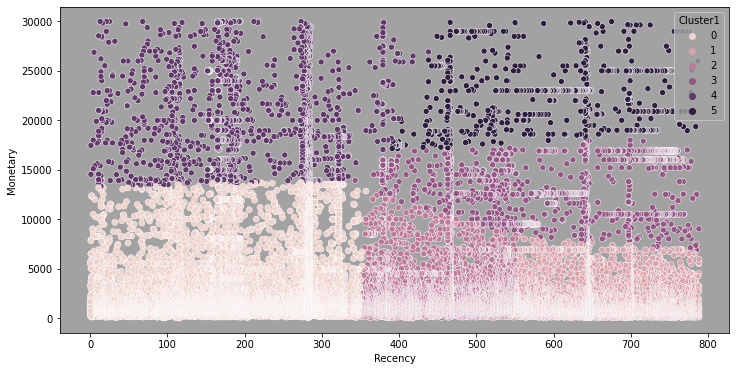

In [34]:
RFM_res = RFM_abs1.copy()
RFM_res['Cluster1'] =cluster.labels_
RFM_one=RFM_res
plt.figure(figsize=(12,6))
sns.scatterplot(RFM_res["Recency"],RFM_res["Monetary"], hue=RFM_res["Cluster1"]);

In [35]:
silhouette_score(RFM,cluster.labels_,metric="sqeuclidean")

0.6457551758846684

In [36]:
RFM_abs1=RFM_abs[(RFM_abs["Frequency"]!=1)&(RFM_abs["Monetary"]<=250000)&(RFM_abs["Frequency"]<=20)]

RFM=RFM_abs1.copy().drop(["Customer ID"],axis=1)
scaler=preprocessing.MinMaxScaler().fit(RFM)
RFM=scaler.transform(RFM)

kmeans=KMeans(n_clusters=5, random_state = seed)
kmeans.fit(RFM)
# add now the predicted cluster to the RFM table
RFM_res = RFM_abs1.copy()
RFM_res['Cluster1'] = kmeans.labels_
RFM_rep=RFM_res

RFMp=RFM_res.drop(["Cluster1"],axis=1)
fig = px.scatter_3d(RFMp, x="Frequency", y="Monetary", z="Recency",labels=RFM_res["Cluster1"], color=RFM_res["Cluster1"])

fig = fig.update_traces(marker=dict(size=2,
                              line=dict(width=2,
                                        color=RFM_res["Cluster1"])),
                  selector=dict(mode='markers'))

fig.layout.showlegend = True
fig.show()


In [37]:
silhouette_score(RFM,kmeans.labels_,metric="sqeuclidean")

0.5665840156608279

## Target Clusters and Marketing Strategy 

##WHO to target

In [35]:
# Proposal: Clusters for Marketing Activity 
# Cluster with low recency and/or high frequency as they tend to show higher likelihood to respond to marketing activities (see literature) 
# Additional cluster under focus with especially high monetary values as they are of special intrest/relevance for company

C1=RFM_one[RFM_one["Cluster1"]==0]
C2=RFM_one[RFM_one["Cluster1"]==4]
C3=RFM_one[RFM_one["Cluster1"]==5]
C4=RFM_rep[RFM_rep["Cluster1"]==2]
C5=RFM_rep[RFM_rep["Cluster1"]==3]
C6=RFM_rep[RFM_rep["Cluster1"]==4]

In [37]:
# 45% customer reach seems to be reasonable and cluster sizes not too small

print((len(C1)+len(C2)+len(C3))/len(RFM_one)*100)
print((len(C4)+len(C5)+len(C6))/len(RFM_rep)*100)
print((len(C1)+len(C2)+len(C3)+len(C4)+len(C5)+len(C6))/(len(RFM_one)+len(RFM_rep))*100)

print(len(C1))
print(len(C2))
print(len(C3))

print(len(C4))
print(len(C5))
print(len(C6))

48.47097268729576
39.524557956778
45.436127105992746
21105
2170
754
1390
7295
1374


In [38]:
#Sub-samples
list1=[]
for id in data["Customer ID"]:
  list1.append(id in np.array(C1["Customer ID"]))
Sub1=data.loc[list1]

list2=[]
for id in data["Customer ID"]:
  list2.append(id in np.array(C2["Customer ID"]))
Sub2=data.loc[list2]

list3=[]
for id in data["Customer ID"]:
  list3.append(id in np.array(C3["Customer ID"]))
Sub3=data.loc[list3]

list4=[]
for id in data["Customer ID"]:
  list4.append(id in np.array(C4["Customer ID"]))
Sub4=data.loc[list4]

list5=[]
for id in data["Customer ID"]:
  list5.append(id in np.array(C5["Customer ID"]))
Sub5=data.loc[list5]

list6=[]
for id in data["Customer ID"]:
  list6.append(id in np.array(C6["Customer ID"]))
Sub6=data.loc[list6]

## HOW to target (offer: product and discount)


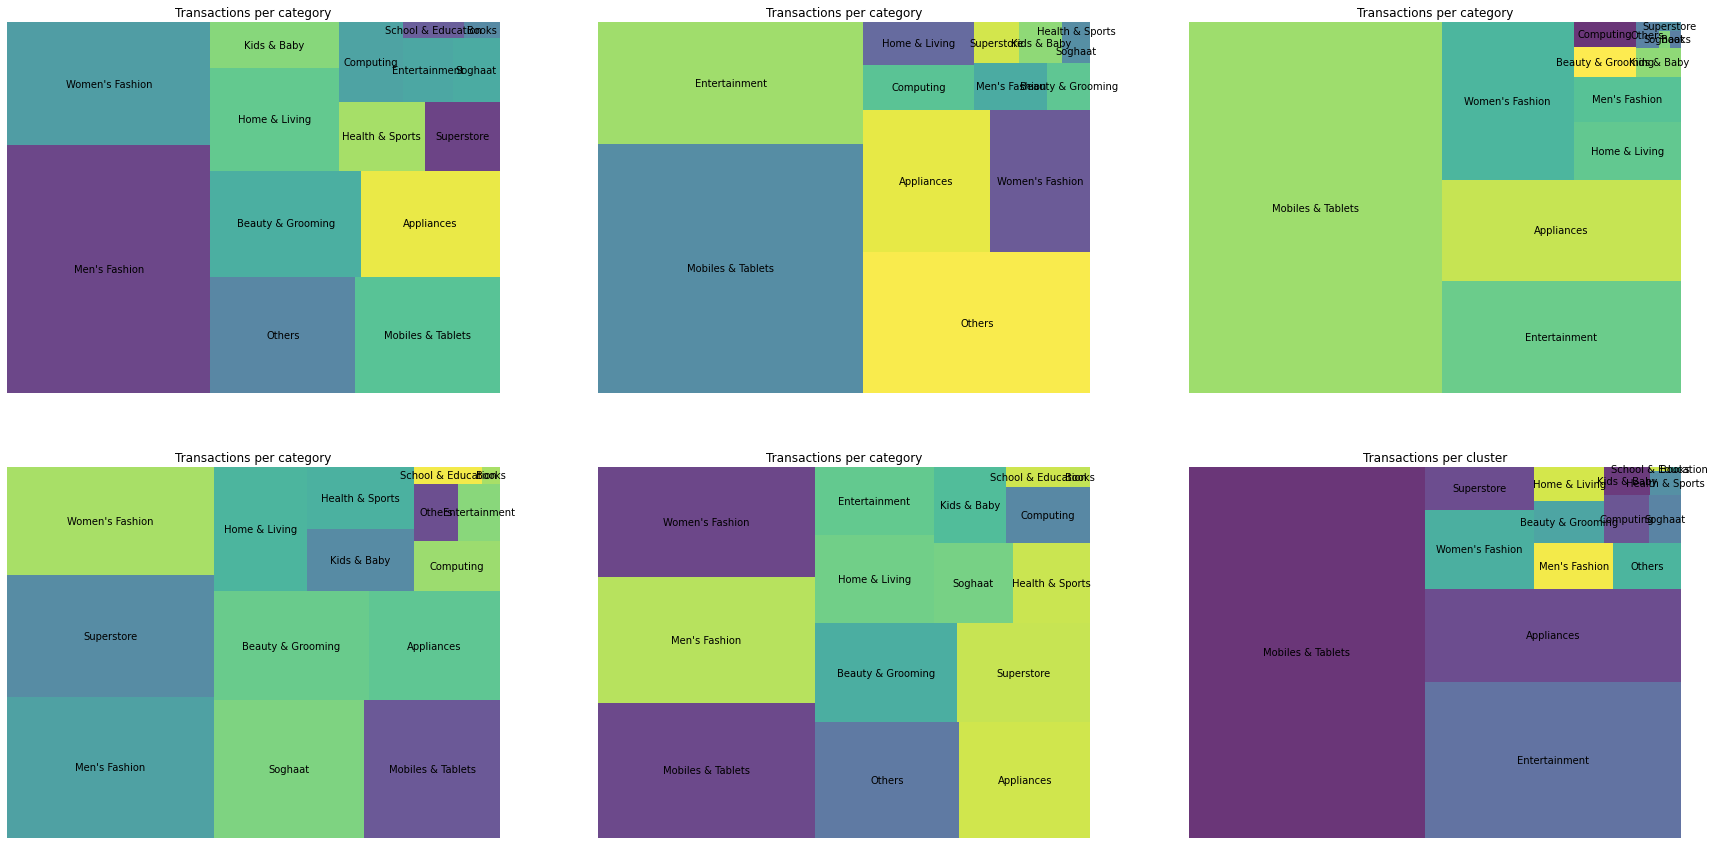

In [39]:
!pip install squarify
import squarify

test1= pd.DataFrame(Sub1["category_name_1"].value_counts())
test1=test1.reset_index()

test2= pd.DataFrame(Sub2["category_name_1"].value_counts())
test2=test2.reset_index()

test3= pd.DataFrame(Sub3["category_name_1"].value_counts())
test3=test3.reset_index()

test4= pd.DataFrame(Sub4["category_name_1"].value_counts())
test4=test4.reset_index()

test5= pd.DataFrame(Sub5["category_name_1"].value_counts())
test5=test5.reset_index()

test6= pd.DataFrame(Sub6["category_name_1"].value_counts())
test6=test6.reset_index()

plt.figure(figsize=(30,15))
plt.subplot(2,3,1)
squarify.plot(sizes=test1["category_name_1"], label=test1["index"], alpha=0.8 )
plt.axis('off')
plt.title("Transactions per category")

plt.subplot(2,3,2)
squarify.plot(sizes=test2["category_name_1"], label=test2["index"], alpha=0.8 )
plt.axis('off')
plt.title("Transactions per category")

plt.subplot(2,3,3)
squarify.plot(sizes=test3["category_name_1"], label=test3["index"], alpha=0.8 )
plt.axis('off')
plt.title("Transactions per category")

plt.subplot(2,3,4)
squarify.plot(sizes=test4["category_name_1"], label=test4["index"], alpha=0.8 )
plt.axis('off')
plt.title("Transactions per category");


plt.subplot(2,3,5)
squarify.plot(sizes=test5["category_name_1"], label=test5["index"], alpha=0.8 )
plt.axis('off')
plt.title("Transactions per category");

plt.subplot(2,3,6)
squarify.plot(sizes=test6["category_name_1"], label=test6["index"], alpha=0.8 )
plt.axis('off')
plt.title("Transactions per cluster");


In [40]:
fill=np.zeros(shape=(6,8))
index=["Cluster1","Cluster2","Cluster3","Cluster4","Cluster5","Cluster6"]
#overview=pd.DataFrame(fill,columns=["AR","AF","AM","RpO","DpO","CpO","CpC"],index=index)
overview=pd.DataFrame(fill,columns=["Rec. per Cust","Freq. per Cust","Monetary per Cust","Revenue per Order","Disocunt per Order ","Categories per Order ","Categories per Customer","Name"],index=index)

In [41]:
# Cluster desciptions / KPIs

#Cluster 1
Average_Recency=C1["Recency"].mean()
Average_Frequency=C1["Frequency"].mean()
Average_Monetary=C1["Monetary"].mean()
group1=Sub1.groupby("increment_id").agg({"grand_item":"sum","discount_rate":"mean","item_id":"count","category_name_1":"nunique"})
Revenue_per_Order= group1["grand_item"].mean()
Discount_per_Order= group1["discount_rate"].mean()
Categories_per_Order= group1["category_name_1"].mean()
group11=Sub1.groupby("Customer ID").agg({"category_name_1":"nunique"})
Categories_per_Customer= group11["category_name_1"].mean()

overview.iloc[0,0]= np.round(Average_Recency,1)
overview.iloc[0,1]= np.round(Average_Frequency,1)
overview.iloc[0,2]= np.round(Average_Monetary,1)
overview.iloc[0,3]= np.round(Revenue_per_Order,1)
overview.iloc[0,4]= np.round(Discount_per_Order,1)
overview.iloc[0,5]= np.round(Categories_per_Order,1)
overview.iloc[0,6]= np.round(Categories_per_Customer,1)

In [42]:
#Cluster 2
Average_Recency=C2["Recency"].mean()
Average_Frequency=C2["Frequency"].mean()
Average_Monetary=C2["Monetary"].mean()
group2=Sub2.groupby("increment_id").agg({"grand_item":"sum","discount_rate":"mean","item_id":"count","category_name_1":"nunique"})
Revenue_per_Order= group2["grand_item"].mean()
Discount_per_Order= group2["discount_rate"].mean()
Categories_per_Order= group2["category_name_1"].mean()
group22=Sub2.groupby("Customer ID").agg({"category_name_1":"nunique"})
Categories_per_Customer= group22["category_name_1"].mean()

overview.iloc[1,0]= np.round(Average_Recency,1)
overview.iloc[1,1]= np.round(Average_Frequency,1)
overview.iloc[1,2]= np.round(Average_Monetary,1)
overview.iloc[1,3]= np.round(Revenue_per_Order,1)
overview.iloc[1,4]= np.round(Discount_per_Order,1)
overview.iloc[1,5]= np.round(Categories_per_Order,1)
overview.iloc[1,6]= np.round(Categories_per_Customer,1)

In [43]:
#Cluster 3
Average_Recency=C3["Recency"].mean()
Average_Frequency=C3["Frequency"].mean()
Average_Monetary=C3["Monetary"].mean()
group3=Sub3.groupby("increment_id").agg({"grand_item":"sum","discount_rate":"mean","item_id":"count","category_name_1":"nunique"})
Revenue_per_Order= group3["grand_item"].mean()
Discount_per_Order= group3["discount_rate"].mean()
Categories_per_Order= group3["category_name_1"].mean()
group33=Sub3.groupby("Customer ID").agg({"category_name_1":"nunique"})
Categories_per_Customer= group33["category_name_1"].mean()

overview.iloc[2,0]= np.round(Average_Recency,1)
overview.iloc[2,1]= np.round(Average_Frequency,1)
overview.iloc[2,2]= np.round(Average_Monetary,1)
overview.iloc[2,3]= np.round(Revenue_per_Order,1)
overview.iloc[2,4]= np.round(Discount_per_Order,1)
overview.iloc[2,5]= np.round(Categories_per_Order,1)
overview.iloc[2,6]= np.round(Categories_per_Customer,1)

In [44]:
#Cluster 4
Average_Recency=C4["Recency"].mean()
Average_Frequency=C4["Frequency"].mean()
Average_Monetary=C4["Monetary"].mean()
group4=Sub4.groupby("increment_id").agg({"grand_item":"sum","discount_rate":"mean","item_id":"count","category_name_1":"nunique"})
Revenue_per_Order= group4["grand_item"].mean()
Discount_per_Order= group4["discount_rate"].mean()
Categories_per_Order= group4["category_name_1"].mean()
group44=Sub4.groupby("Customer ID").agg({"category_name_1":"nunique"})
Categories_per_Customer= group44["category_name_1"].mean()

overview.iloc[3,0]= np.round(Average_Recency,1)
overview.iloc[3,1]= np.round(Average_Frequency,1)
overview.iloc[3,2]= np.round(Average_Monetary,1)
overview.iloc[3,3]= np.round(Revenue_per_Order,1)
overview.iloc[3,4]= np.round(Discount_per_Order,1)
overview.iloc[3,5]= np.round(Categories_per_Order,1)
overview.iloc[3,6]= np.round(Categories_per_Customer,1)

In [45]:
#Cluster 5
Average_Recency=C5["Recency"].mean()
Average_Frequency=C5["Frequency"].mean()
Average_Monetary=C5["Monetary"].mean()
group5=Sub5.groupby("increment_id").agg({"grand_item":"sum","discount_rate":"mean","item_id":"count","category_name_1":"nunique"})
Revenue_per_Order= group5["grand_item"].mean()
Discount_per_Order= group5["discount_rate"].mean()
Categories_per_Order= group5["category_name_1"].mean()
group55=Sub5.groupby("Customer ID").agg({"category_name_1":"nunique"})
Categories_per_Customer= group55["category_name_1"].mean()

overview.iloc[4,0]= np.round(Average_Recency,1)
overview.iloc[4,1]= np.round(Average_Frequency,1)
overview.iloc[4,2]= np.round(Average_Monetary,1)
overview.iloc[4,3]= np.round(Revenue_per_Order,1)
overview.iloc[4,4]= np.round(Discount_per_Order,1)
overview.iloc[4,5]= np.round(Categories_per_Order,1)
overview.iloc[4,6]= np.round(Categories_per_Customer,1)

In [46]:
#Cluster 6
Average_Recency=C6["Recency"].mean()
Average_Frequency=C6["Frequency"].mean()
Average_Monetary=C6["Monetary"].mean()
group6=Sub6.groupby("increment_id").agg({"grand_item":"sum","discount_rate":"mean","item_id":"count","category_name_1":"nunique"})
Revenue_per_Order= group6["grand_item"].mean()
Discount_per_Order= group6["discount_rate"].mean()
Categories_per_Order= group6["category_name_1"].mean()
group66=Sub6.groupby("Customer ID").agg({"category_name_1":"nunique"})
Categories_per_Customer= group66["category_name_1"].mean()

overview.iloc[5,0]= np.round(Average_Recency,1)
overview.iloc[5,1]= np.round(Average_Frequency,1)
overview.iloc[5,2]= np.round(Average_Monetary,1)
overview.iloc[5,3]= np.round(Revenue_per_Order,1)
overview.iloc[5,4]= np.round(Discount_per_Order,1)
overview.iloc[5,5]= np.round(Categories_per_Order,1)
overview.iloc[5,6]= np.round(Categories_per_Customer,1)

In [47]:
overview.iloc[0,7]= "Up-seller"
overview.iloc[1,7]= "Keepers"
overview.iloc[2,7]= "Re-Activaters"
overview.iloc[3,7]= "Loyal-Shoppers"
overview.iloc[4,7]= "High-Potentials"
overview.iloc[5,7]= "Top Group"

overview


Rec. per Cust  Freq. per Cust  Monetary per Cust  Revenue per Order  \
Cluster1          200.6             1.0             2620.3             2620.3   
Cluster2          207.8             1.0            20287.4            20287.4   
Cluster3          587.3             1.0            22526.7            22526.7   
Cluster4          234.9            12.1            31613.1             2602.8   
Cluster5          122.9             3.1            16542.1             5363.6   
Cluster6          167.7             7.5           122595.1            16393.7   

          Disocunt per Order   Categories per Order   Categories per Customer  \
Cluster1                  2.2                    1.1                      1.1   
Cluster2                  6.3                    1.1                      1.1   
Cluster3                  3.3                    1.1                      1.1   
Cluster4                  6.7                    1.2                      5.4   
Cluster5                  5.6                    1.2                      2.0   
Cluster6                 12.5                    1.0                      1.8   

                     Name  
Cluster1        Up-seller  
Cluster2          Keepers  
Cluster3    Re-Activaters  
Cluster4   Loyal-Shoppers  
Cluster5  High-Potentials  
Cluster6        Top Group

In [49]:
# df2=pd.read_csv("Pakistan Largest Ecommerce Dataset.csv")
df2=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Pakistan Largest Ecommerce Dataset.csv")
df2.dropna(axis=0,how='all',inplace=True)
df2.dropna(axis=1,how='all',inplace=True)
df2.dropna(axis=0,how='any',inplace=True, subset=['Customer ID'])
df2["BI Status"]=df2["BI Status"].replace(to_replace=['#REF!'],value=["Net"])
df2['BIstatus_num'] = df2['BI Status']
df2['BIstatus_num'] = df2['BIstatus_num'].replace(['Net'], 1)
df2['BIstatus_num'] = df2['BIstatus_num'].replace(['Valid'], 0)
df2['BIstatus_num'] = df2['BIstatus_num'].replace(['Gross'], -1)
df2['status_new'] = df2['status']
df2['status_new'] = df2['status_new'].replace(['order_refunded', 'refund'],'refunded')
df2['status_new'] = df2['status_new'].replace(['complete', 'closed'],'completed')
df2['status_new'] = df2['status_new'].replace(['paid','received','cod',"exchange"],'processing')
df2['status_new'] = df2['status_new'].replace(['holded','pending_paypal','payment_review'],'pending')
df2=df2[df2["price"]>0]
df2=df2[df2["grand_total"]>0]
df2['discount_rate'] = (df2['discount_amount']/(df2['grand_total'] + df2['discount_amount']) * 100).round(2)
df2['grand_item']=df2['price']*df2["qty_ordered"]*(1-df2['discount_rate']/100)
df2=df2[df2["category_name_1"]!='\\N']
df2=df2.drop(["sales_commission_code"],axis=1)
df2=df2.dropna(axis=0,how="any")

In [50]:
Gd=df2.groupby(["increment_id"]).agg({"discount_rate":"mean","BIstatus_num":np.unique})
Gd["l"]=pd.cut(Gd["discount_rate"],bins=[-5,0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100],
          labels=["l1","l2","l3","l4","l5","l6","l7","l8","l9","l10","l11","l12","l13","l14","l15","l16","l17","l18","l19","l20","l21"])
res=[]
for i in ["l1","l2","l3","l4","l5","l6","l7","l8","l9","l10","l11","l12","l13","l14","l15","l16","l17","l18","l19","l20","l21"]:
  a=len(Gd[(Gd["BIstatus_num"]==1)&(Gd["l"]==i)])/len(Gd[Gd["l"]==i])*100
  res.append(a)

Discount=[0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100]
Share_of_completed =res

fig = px.line(x=Discount,y=Share_of_completed)
fig.update_traces(mode="markers+lines", hovertemplate=None) 
fig.update_layout(hovermode="x unified")
fig.update_layout(height=600, width=800, title_text="Share of completed/closed orders per discount-level")
fig.update_xaxes(title_text="Discount-level")
fig.update_yaxes(title_text="Share of completed orders")
fig.show();

In [51]:
neu=['Appliances', 'Entertainment', "Men's Fashion", 'Mobiles & Tablets', 'Superstore', "Women's Fashion"]
neu2=[0, 1, 2, 3, 4, 5]

x=np.zeros(shape=(21,6))
for inte,word in zip(neu2, neu):
  dfx=df2[df2["category_name_1"]==word]
  Gd=dfx.groupby(["increment_id"]).agg({"discount_rate":"mean","BIstatus_num":np.unique})
  Gd["l"]=pd.cut(Gd["discount_rate"],bins=[-5,0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100],
          labels=["l1","l2","l3","l4","l5","l6","l7","l8","l9","l10","l11","l12","l13","l14","l15","l16","l17","l18","l19","l20","l21"])
  res=[]
  for i in ["l1","l2","l3","l4","l5","l6","l7","l8","l9","l10","l11","l12","l13","l14","l15","l16","l17","l18","l19","l20","l21"]:
    a=len(Gd[(Gd["BIstatus_num"]==1)&(Gd["l"]==i)])/len(Gd[Gd["l"]==i])*100
    res.append(a)
  x[:,inte]=res

In [52]:
from plotly.subplots import make_subplots
import plotly.graph_objects as gx
z=[0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100]

fig = make_subplots(rows=2, cols=3,
subplot_titles=("Appliances","Entertainment","Men's Fashion","Mobiles & Tablets", "Superstore","Women's Fashion"),
shared_xaxes=True, shared_yaxes=True)

fig.add_trace(
    gx.Scatter(x=z, y=x[:,0]),
    row=1, col=1
)

fig.add_trace(
    gx.Scatter(x=z, y=x[:,1]),
    row=1, col=2
)

fig.add_trace(
    gx.Scatter(x=z, y=x[:,2]),
    row=1, col=3
)

fig.add_trace(
    gx.Scatter(x=z, y=x[:,3]),
    row=2, col=1
)

fig.add_trace(
    gx.Scatter(x=z, y=x[:,4]),
    row=2, col=2
)

fig.add_trace(
    gx.Scatter(x=z, y=x[:,5]),
    row=2, col=3
)

fig.update_layout(height=600, width=1200, title_text="Share of completed/closed orders per discount-level")
fig.show()

## WHEN to target

In [53]:
#Time Series Analysis

#Deep dive into the clusters of part 2, to get an idea which products we could push with marketing
#most interesstings groups are group 0 and 4. both have a short recency. additionaly look deeper into group 5 (heigher recnecy but also a high monetary score)

#create CSV which contains result of cluster 1
RFM_res_merged = data.merge(right=RFM_one.reset_index(),on='Customer ID',how='left')
#RFM_res_merged = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Result_Cluster1.csv')
RFM_res_merged.head()


item_id    status created_at  \
0  211131.0  complete   7/1/2016   
1  211139.0  complete   7/1/2016   
2  211142.0  complete   7/1/2016   
3  211143.0  received   7/1/2016   
4  211144.0  received   7/1/2016   

                                                sku   price  qty_ordered  \
0                                 kreations_YI 06-L  1950.0          1.0   
1                      UK_Namkino Mix Nimco 400 Gms   170.0          1.0   
2  GFC_Pedestal Myga Cross Base (Special Guard) 24"  5500.0          1.0   
3                                       BK1070200PL   210.0          1.0   
4                                       BK1130200CF   156.0          1.0   

   grand_total increment_id  category_name_1  discount_amount  ... Lifetime  \
0       1950.0    100147443  Women's Fashion              0.0  ...    789.0   
1        170.0    100147450          Soghaat              0.0  ...    789.0   
2       5500.0    100147453       Appliances              0.0  ...    789.0   
3        366.0    100147454          Soghaat              0.0  ...    789.0   
4        366.0    100147454          Soghaat              0.0  ...    789.0   

  Most_Recent_Purchase Recency_x Frequency_x  Monetary_x  index Recency_y  \
0           2016-07-01     788.0           1      1950.0    0.0     788.0   
1           2016-07-01     788.0           1       170.0    7.0     788.0   
2           2016-07-01     788.0           1      5500.0   10.0     788.0   
3           2016-07-01     788.0           1       366.0   11.0     788.0   
4           2016-07-01     788.0           1       366.0   11.0     788.0   

  Frequency_y Monetary_y  Cluster1  
0         1.0     1950.0       1.0  
1         1.0      170.0       1.0  
2         1.0     5500.0       1.0  
3         1.0      366.0       1.0  
4         1.0      366.0       1.0  

[5 rows x 37 columns]

In [54]:
# RFM_res_merged.to_csv("Result_Cluster1.csv",index=False)
RFM_res_merged.to_csv("/content/drive/MyDrive/Colab Notebooks/Result_Cluster1.csv",index=False)

# RFM_res_merged_TS = pd.read_csv('Result_Cluster1.csv', index_col=2, parse_dates=[2], squeeze=True)
RFM_res_merged_TS = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Result_Cluster1.csv', index_col=2, parse_dates=[2], squeeze=True)

RFM_res_merged_TS.head(10)

item_id    status  \
created_at                       
2016-07-01  211131.0  complete   
2016-07-01  211139.0  complete   
2016-07-01  211142.0  complete   
2016-07-01  211143.0  received   
2016-07-01  211144.0  received   
2016-07-01  211145.0  complete   
2016-07-01  211155.0  complete   
2016-07-01  211156.0  complete   
2016-07-01  211166.0  complete   
2016-07-01  211174.0  complete   

                                                         sku   price  \
created_at                                                             
2016-07-01                                 kreations_YI 06-L  1950.0   
2016-07-01                      UK_Namkino Mix Nimco 400 Gms   170.0   
2016-07-01  GFC_Pedestal Myga Cross Base (Special Guard) 24"  5500.0   
2016-07-01                                       BK1070200PL   210.0   
2016-07-01                                       BK1130200CF   156.0   
2016-07-01                                      kcc_Sultanat   120.0   
2016-07-01                                         J&J_JJR-4   149.0   
2016-07-01                                        J&J_JJR-20   149.0   
2016-07-01                     Ctees-Black Zip- Up Hoodie-XL   450.0   
2016-07-01                                       JBS_TAT-128  3672.0   

            qty_ordered  grand_total increment_id  category_name_1  \
created_at                                                           
2016-07-01          1.0       1950.0    100147443  Women's Fashion   
2016-07-01          1.0        170.0    100147450          Soghaat   
2016-07-01          1.0       5500.0    100147453       Appliances   
2016-07-01          1.0        366.0    100147454          Soghaat   
2016-07-01          1.0        366.0    100147454          Soghaat   
2016-07-01          1.0        120.0    100147455    Home & Living   
2016-07-01          1.0        298.0    100147460      Kids & Baby   
2016-07-01          1.0        298.0    100147460      Kids & Baby   
2016-07-01          1.0        450.0    100147465      Kids & Baby   
2016-07-01          1.0       3672.0    100147470    Home & Living   

            discount_amount payment_method  ... Lifetime Most_Recent_Purchase  \
created_at                                  ...                                 
2016-07-01              0.0            cod  ...    789.0           2016-07-01   
2016-07-01              0.0            cod  ...    789.0           2016-07-01   
2016-07-01              0.0            cod  ...    789.0           2016-07-01   
2016-07-01              0.0            cod  ...    789.0           2016-07-01   
2016-07-01              0.0            cod  ...    789.0           2016-07-01   
2016-07-01              0.0         Credit  ...    789.0           2017-02-14   
2016-07-01              0.0            cod  ...    789.0           2018-01-09   
2016-07-01              0.0            cod  ...    789.0           2018-01-09   
2016-07-01              0.0            cod  ...    789.0           2016-11-22   
2016-07-01              0.0            cod  ...    789.0           2018-07-05   

           Recency_x  Frequency_x  Monetary_x index Recency_y Frequency_y  \
created_at                                                                  
2016-07-01     788.0            1    1950.000   0.0     788.0         1.0   
2016-07-01     788.0            1     170.000   7.0     788.0         1.0   
2016-07-01     788.0            1    5500.000  10.0     788.0         1.0   
2016-07-01     788.0            1     366.000  11.0     788.0         1.0   
2016-07-01     788.0            1     366.000  11.0     788.0         1.0   
2016-07-01     560.0            4     945.000   NaN       NaN         NaN   
2016-07-01     231.0           13   19834.176   NaN       NaN         NaN   
2016-07-01     231.0           13   19834.176   NaN       NaN         NaN   
2016-07-01     644.0           10    5526.000   NaN       NaN         NaN   
2016-07-01      54.0           14   29576.400   NaN       NaN         NaN   



In [55]:
RFM_res_merged_Cluster0 = RFM_res_merged[RFM_res_merged['Cluster1']==0]
RFM_res_merged_Cluster4 = RFM_res_merged[RFM_res_merged['Cluster1']==4]
RFM_res_merged_Cluster5 = RFM_res_merged[RFM_res_merged['Cluster1']==5]


#build dataset which contains only data of group 0,4,5 and investigate data in a time series analysis
RFM_res_merged_Cluster_TS = RFM_res_merged_TS[(RFM_res_merged_TS['Cluster1']==0) | (RFM_res_merged_TS['Cluster1']==4) | (RFM_res_merged_TS['Cluster1']==5) ]

RFM_res_merged_Cluster_TS_1 = RFM_res_merged_Cluster_TS['Frequency_x']

In [56]:
RFM_res_merged_Cluster_TS_count = RFM_res_merged_Cluster_TS.groupby(['created_at', 'Cluster1']).agg('count')
RFM_res_merged_Cluster_TS_count = RFM_res_merged_Cluster_TS_count.reset_index()
RFM_res_merged_Cluster_TS_count

fig = px.line(RFM_res_merged_Cluster_TS_count, x='created_at', y='item_id', color='Cluster1', title='<b>Count transactions per day - separated by observed groups (0,4,5) - One time customer</b>')
fig.update_xaxes(rangeslider_visible=True)

fig.show()


Observations: there are manily two peaks in the timeline to investigate .

*   First between 17.11 - 24.11 - this was the black friday week in Pakistan
*   Second import peak was end of march 2018. during this period starting mid till end of march is an historical national day (23.03.) around this period there happens a lot of sales activies in the entire country, so this is an important period to make special offers

In [57]:
# do the same analysis on the second group - they bought more than one times

RFM_res_merged = data.merge(right=RFM_rep.reset_index(),on='Customer ID',how='left')

# RFM_res_merged.to_csv("Result_Cluster1_3d.csv",index=False)
RFM_res_merged.to_csv("/content/drive/MyDrive/Colab Notebooks/Result_Cluster1_3d.csv",index=False)

# RFM_res_merged_3d_TS = pd.read_csv('Result_Cluster1_3d.csv', index_col=2, parse_dates=[2], squeeze=True)
RFM_res_merged_3d_TS = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Result_Cluster1_3d.csv', index_col=2, parse_dates=[2], squeeze=True)

RFM_res_merged_3d_TS.head()

#RFM_res_merged_TS = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Result_Cluster1_3d.csv', index_col=2, parse_dates=[2], squeeze=True)

#RFM_res_merged_3d_TS = data.merge(right=RFM_res_merged_TS.reset_index(),on='Customer ID',how='left')
#RFM_res_merged_3d_TS.head()


item_id    status  \
created_at                       
2016-07-01  211131.0  complete   
2016-07-01  211139.0  complete   
2016-07-01  211142.0  complete   
2016-07-01  211143.0  received   
2016-07-01  211144.0  received   

                                                         sku   price  \
created_at                                                             
2016-07-01                                 kreations_YI 06-L  1950.0   
2016-07-01                      UK_Namkino Mix Nimco 400 Gms   170.0   
2016-07-01  GFC_Pedestal Myga Cross Base (Special Guard) 24"  5500.0   
2016-07-01                                       BK1070200PL   210.0   
2016-07-01                                       BK1130200CF   156.0   

            qty_ordered  grand_total increment_id  category_name_1  \
created_at                                                           
2016-07-01          1.0       1950.0    100147443  Women's Fashion   
2016-07-01          1.0        170.0    100147450          Soghaat   
2016-07-01          1.0       5500.0    100147453       Appliances   
2016-07-01          1.0        366.0    100147454          Soghaat   
2016-07-01          1.0        366.0    100147454          Soghaat   

            discount_amount payment_method  ... Lifetime Most_Recent_Purchase  \
created_at                                  ...                                 
2016-07-01              0.0            cod  ...    789.0           2016-07-01   
2016-07-01              0.0            cod  ...    789.0           2016-07-01   
2016-07-01              0.0            cod  ...    789.0           2016-07-01   
2016-07-01              0.0            cod  ...    789.0           2016-07-01   
2016-07-01              0.0            cod  ...    789.0           2016-07-01   

           Recency_x  Frequency_x  Monetary_x index Recency_y Frequency_y  \
created_at                                                                  
2016-07-01     788.0            1      1950.0   NaN       NaN         NaN   
2016-07-01     788.0            1       170.0   NaN       NaN         NaN   
2016-07-01     788.0            1      5500.0   NaN       NaN         NaN   
2016-07-01     788.0            1       366.0   NaN       NaN         NaN   
2016-07-01     788.0            1       366.0   NaN       NaN         NaN   

            Monetary_y  Cluster1  
created_at                        
2016-07-01         NaN       NaN  
2016-07-01         NaN       NaN  
2016-07-01         NaN       NaN  
2016-07-01         NaN       NaN  
2016-07-01         NaN       NaN  

[5 rows x 36 columns]

In [58]:
RFM_res_merged_3d_TS = RFM_res_merged_3d_TS[(RFM_res_merged_3d_TS['Cluster1']==2) | (RFM_res_merged_3d_TS['Cluster1']==3) | (RFM_res_merged_3d_TS['Cluster1']==4) ]

RFM_res_merged_3d_TS_count = RFM_res_merged_3d_TS.groupby(['created_at', 'Cluster1']).agg('count')
RFM_res_merged_3d_TS_count = RFM_res_merged_3d_TS_count.reset_index()
RFM_res_merged_3d_TS_count['created_at'] = pd.to_datetime(RFM_res_merged_3d_TS_count['created_at'])
RFM_res_merged_3d_TS_count = RFM_res_merged_3d_TS_count.sort_values(by='created_at')

RFM_res_merged_3d_TS_count.head(5)


created_at  Cluster1  item_id  status  sku  price  qty_ordered  grand_total  \
0 2016-07-01       2.0       14      14   14     14           14           14   
1 2016-07-01       3.0        2       2    2      2            2            2   
2 2016-07-02       2.0        9       9    9      9            9            9   
3 2016-07-02       3.0        3       3    3      3            3            3   
4 2016-07-03       2.0       11      11   11     11           11           11   

   increment_id  category_name_1  ...  Customer_Since_Date  Lifetime  \
0            14               14  ...                   14        14   
1             2                2  ...                    2         2   
2             9                9  ...                    9         9   
3             3                3  ...                    3         3   
4            11               11  ...                   11        11   

   Most_Recent_Purchase  Recency_x  Frequency_x  Monetary_x  index  Recency_y  \
0                    14         14           14          14     14         14   
1                     2          2            2           2      2          2   
2                     9          9            9           9      9          9   
3                     3          3            3           3      3          3   
4                    11         11           11          11     11         11   

   Frequency_y  Monetary_y  
0           14          14  
1            2           2  
2            9           9  
3            3           3  
4           11          11  

[5 rows x 37 columns]

In [60]:
fig = px.line(RFM_res_merged_3d_TS_count, x='created_at', y='item_id', color='Cluster1', title='<b>Count transactions per day - separated by observed groups (2,3,4) - recurring customer</b>')
fig.update_xaxes(rangeslider_visible=True)

fig.show()

In [61]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

RFM_res_merged_Cluster_TS_count_2 = RFM_res_merged_Cluster_TS.groupby('created_at').count()
RFM_res_merged_Cluster_TS_count_2 = RFM_res_merged_Cluster_TS_count_2.reset_index()

RFM_res_merged_Cluster_TS_mean_discount_rate = RFM_res_merged_Cluster_TS
RFM_res_merged_Cluster_TS_mean_discount_rate = RFM_res_merged_Cluster_TS_mean_discount_rate.reset_index()
RFM_res_merged_Cluster_TS_mean_discount_rate =RFM_res_merged_Cluster_TS_mean_discount_rate.groupby(['created_at'])['discount_rate'].mean()

RFM_res_merged_Cluster_TS_mean_discount_rate = RFM_res_merged_Cluster_TS_mean_discount_rate.reset_index()
RFM_res_merged_Cluster_TS_mean_discount_rate[RFM_res_merged_Cluster_TS_mean_discount_rate['created_at']=='2018-03-18']
RFM_res_merged_Cluster_TS_mean_discount_rate


# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])


# Add traces
fig.add_trace(
    go.Scatter(x=RFM_res_merged_Cluster_TS_count_2['created_at'], y=RFM_res_merged_Cluster_TS_count_2['item_id'], name="Overall transactions per day"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=RFM_res_merged_Cluster_TS_mean_discount_rate['created_at'],y=RFM_res_merged_Cluster_TS_mean_discount_rate['discount_rate'], name="Mean Discount rate per day"),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="<b>Overall transactions (Groups 0,4,5) vs Average Discount Rate - One Time Customer</b>"
)

# Set x-axis title
fig.update_xaxes(title_text="xaxis title")

# Set y-axes titles
fig.update_yaxes(title_text="<b>Transactions</b>", secondary_y=False)
fig.update_yaxes(title_text="<b>Mean discount rate</b>", secondary_y=True)

fig.update_xaxes(rangeslider_visible=True)

fig.show()

**Observation:** We can see there are a lot of discount activities on the timeline, but most of them did not drive the sales activities. So we should think about how we want to deal with those discount rates in future

In [62]:
# start hier with analysis of recurring customers

RFM_res_merged_3d_TS = RFM_res_merged_3d_TS[(RFM_res_merged_3d_TS['Cluster1']==2) | (RFM_res_merged_3d_TS['Cluster1']==3) | (RFM_res_merged_3d_TS['Cluster1']==4) ]

RFM_res_merged_3d_TS_count_2 = RFM_res_merged_3d_TS.groupby('created_at').count()
RFM_res_merged_3d_TS_count_2 = RFM_res_merged_3d_TS_count_2.reset_index()

RFM_res_merged_3d_TS_count_2['created_at'] = pd.to_datetime(RFM_res_merged_3d_TS_count_2['created_at'])
RFM_res_merged_3d_TS_count_2 = RFM_res_merged_3d_TS_count_2.sort_values(by='created_at')




RFM_res_merged_3d_TS_mean_discount_rate = RFM_res_merged_3d_TS
RFM_res_merged_3d_TS_mean_discount_rate = RFM_res_merged_3d_TS_mean_discount_rate.reset_index()
RFM_res_merged_3d_TS_mean_discount_rate =RFM_res_merged_3d_TS_mean_discount_rate.groupby(['created_at'])['discount_rate'].mean()

RFM_res_merged_3d_TS_mean_discount_rate = RFM_res_merged_3d_TS_mean_discount_rate.reset_index()

RFM_res_merged_3d_TS_mean_discount_rate['created_at'] = pd.to_datetime(RFM_res_merged_3d_TS_mean_discount_rate['created_at'])
RFM_res_merged_3d_TS_mean_discount_rate = RFM_res_merged_3d_TS_mean_discount_rate.sort_values(by='created_at')

#RFM_res_merged_3d_TS_mean_discount_rate[RFM_res_merged_3d_TS_mean_discount_rate['created_at']=='2018-03-18']

#RFM_res_merged_3d_TS_count_2

# # Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])


# Add traces
fig.add_trace(
    go.Scatter(x=RFM_res_merged_3d_TS_count_2['created_at'], y=RFM_res_merged_3d_TS_count_2['item_id'], name="Overall transactions per day"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=RFM_res_merged_3d_TS_mean_discount_rate['created_at'],y=RFM_res_merged_3d_TS_mean_discount_rate['discount_rate'], name="Mean Discount rate per day"),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="<b>Overall transactions (Groups 2,3,4) vs Average Discount Rate (Recurring Customers)</b>"
)

# Set x-axis title
fig.update_xaxes(title_text="xaxis title")

# Set y-axes titles
fig.update_yaxes(title_text="<b>Transactions</b>", secondary_y=False)
fig.update_yaxes(title_text="<b>Mean discount rate</b>", secondary_y=True)

fig.update_xaxes(rangeslider_visible=True)

fig.show()


**Observation:**
Compared to previous analysis of one time customer, we can see here that in many cases when we offer higher discount rates, the customer bought more on those days.
Trends can also be seen here: e.g. Black Friday week in 2016 (Nov), 2017 (Nov) or again the end of March sales on the national day

## Further discount rate analysis

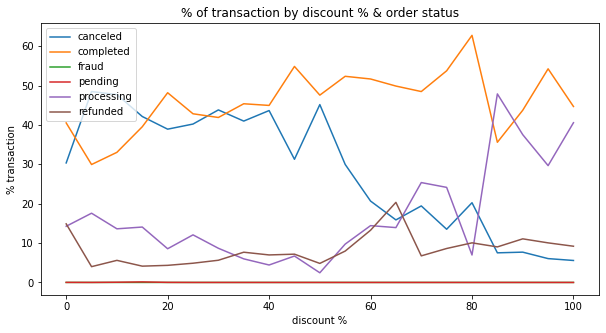

In [63]:
df2['discount_group'] = pd.cut(df2["discount_rate"],bins=[-5,0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100],
                              labels=[0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100])

disc_status = (100*df2.groupby(['discount_group','status_new'])['status_new'].count() / df2.groupby(['discount_group'])['status_new'].count()).rename("ratio").reset_index()
disc_status['discount_group'] = disc_status.discount_group.astype('int')

plt.figure(figsize=(10,5))
sns.lineplot(x='discount_group',y='ratio',hue='status_new',data=disc_status)
plt.ylabel('% transaction')
plt.xlabel('discount %')
plt.title('% of transaction by discount % & order status')
plt.legend()
plt.show()

# There are obvious trends in order status 'canceled', 'completed'/'processing', which we will look into below

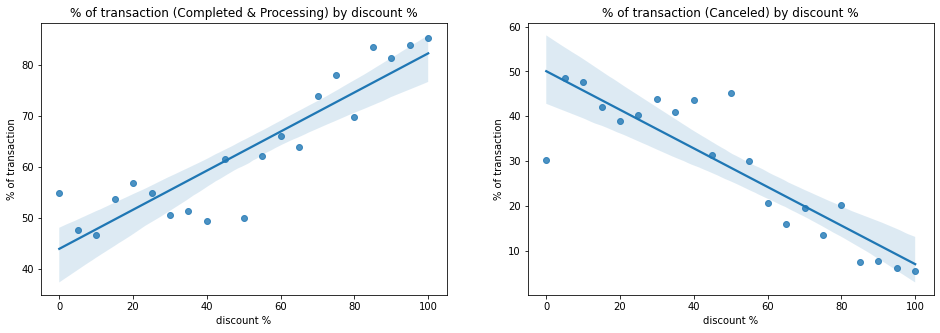

In [64]:
fig_data1=disc_status[(disc_status.status_new=='completed')|(disc_status.status_new=='processing')]
fig_data1=fig_data1.groupby(['discount_group'])['ratio'].sum().reset_index()
fig_data2=disc_status[(disc_status.status_new=='canceled')]

plt.figure(figsize=(16,5))
plt.subplot(121)
sns.regplot(x='discount_group',y='ratio',data=fig_data1)
plt.ylabel('% of transaction')
plt.xlabel('discount %')
plt.title('% of transaction (Completed & Processing) by discount %')

plt.subplot(122)
sns.regplot(x='discount_group',y='ratio',data=fig_data2)
plt.ylabel('% of transaction')
plt.xlabel('discount %')
plt.title('% of transaction (Canceled) by discount %')
plt.show()

**Observations:**
- The higher the discount %, the higher % of transaction completed and processing
- Also the higher the discount %, the lower the % of transaction canceled

**from number perspective:**
- 30% discount >> 50% of transactions were completed/processing, and 40% cancaled
- 50% discount >> 60% of transactions were completed/processing, and 30% cancaled
- 80% discount >> 70% of transactions were completed/processing, and 20% cancaled

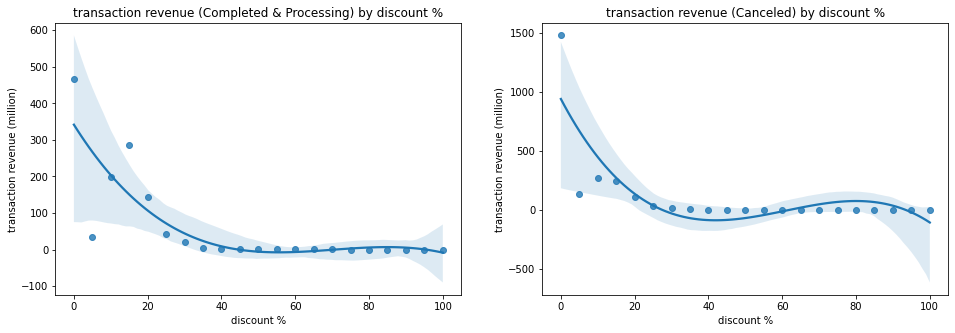

In [65]:
disc_revenue = (df2.groupby(['discount_group','status_new'])['grand_item'].sum()/1e6).reset_index()
disc_revenue['discount_group'] = disc_revenue.discount_group.astype('int')

fig_data3=disc_revenue[(disc_status.status_new=='completed')|(disc_status.status_new=='processing')]
fig_data3=fig_data3.groupby(['discount_group'])['grand_item'].sum().reset_index()
fig_data4=disc_revenue[(disc_status.status_new=='canceled')]

plt.figure(figsize=(16,5))
plt.subplot(121)
sns.regplot(x='discount_group',y='grand_item',data=fig_data3,order=3)
plt.ylabel('transaction revenue (million)')
plt.xlabel('discount %')
plt.title('transaction revenue (Completed & Processing) by discount %')

plt.subplot(122)
sns.regplot(x='discount_group',y='grand_item',data=fig_data4,order=3)
plt.ylabel('transaction revenue (million)')
plt.xlabel('discount %')
plt.title('transaction revenue (Canceled) by discount %')
plt.show()

**Observations:**
- for completed and processing orders, 99% of revenues came from discount % <= 30%, 80% of revenues came from discount % <= 15%
- similarly for canceled orders, 99% of revenues came from discount % <= 30%, 80% of revenues came from discount % <= 10%
                                      
Note: total completed/processing revenues were 1205 million, whereas canceled revenues were 2308 million. i.e. almost double the amounts of completed/processing

Text(0.5, 1.0, 'Revenue Weighted Discount % by Year Month')

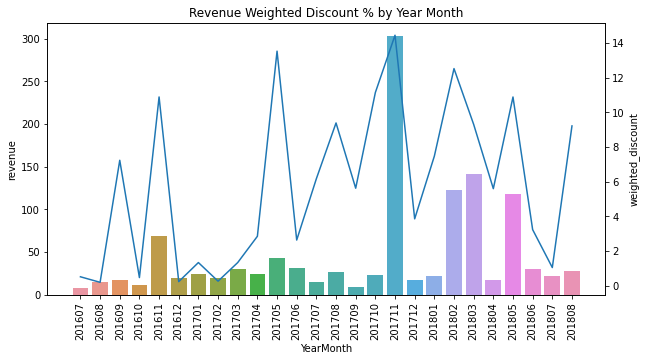

In [66]:
# for completed/processing transactions

df2['YearMonth'] = (df2.Year*100 + df2.Month).astype(int).astype(str)
t1=df2[(df2.status_new=='completed')|(df2.status_new=='processing')]
t1=(t1.groupby(['YearMonth','discount_group'])['grand_item'].sum()/1e6).reset_index()
t1['discount_group'] = t1.discount_group.astype('int')
# calculate weighted discount % by year month
t1['discount_x_revenue'] =  t1.discount_group * t1.grand_item
t1=t1.groupby(['YearMonth'])['grand_item','discount_x_revenue'].sum().reset_index()
t1['weighted_discount'] = t1.discount_x_revenue/t1.grand_item

plt.figure(figsize=(10,5))
ax=sns.barplot(x='YearMonth',y='grand_item',data=t1)
plt.ylabel('revenue')
plt.xticks(rotation=90)
ax2 = ax.twinx()
sns.lineplot(x='YearMonth',y='weighted_discount',data=t1,ax=ax2)
plt.title('Revenue Weighted Discount % by Year Month')

**Observations:**
- Marketing campagins / high discount rates were mainly in Feb, May, Aug/Sep, Oct/Nov
- Feb 2017 vs Feb 2018: 0.3% vs 12.5% discount%, 19 millions vs 123 millions. i.e. revenue increased by over 500% by offer discounts
- May 2017 vs May 2018: 13.5% vs 10.9% discount%, 43 millions vs 117 millions. i.e. revenue increased also with similar discount offered / slight lower discount
- Nov 2016 vs May 2017: 10.9% vs 14.5% discount%, 68 millions vs 303 millions. i.e. revenue increased by over 300% by increasing discount  

Hence, discount is not the only driving force for the increase in revenue. Change in category targeting / category analysis should be investigated

Text(0.5, 1.0, 'Revenue Weighted Discount % by Year Month')

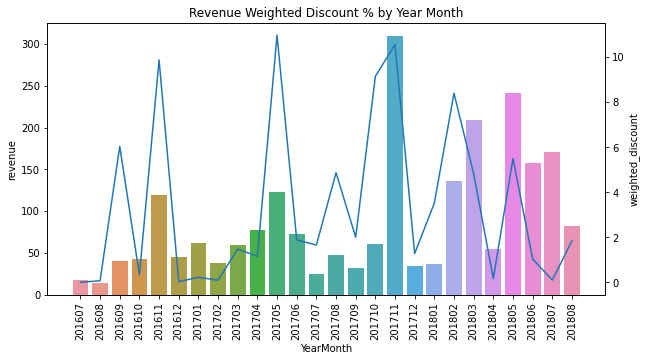

In [67]:
# for canceled transactions

df2['YearMonth'] = (df2.Year*100 + df2.Month).astype(int).astype(str)
t1=df2[(df2.status_new=='canceled')]
t1=(t1.groupby(['YearMonth','discount_group'])['grand_item'].sum()/1e6).reset_index()
t1['discount_group'] = t1.discount_group.astype('int')
# calculate weighted discount % by year month
t1['discount_x_revenue'] =  t1.discount_group * t1.grand_item
t1=t1.groupby(['YearMonth'])['grand_item','discount_x_revenue'].sum().reset_index()
t1['weighted_discount'] = t1.discount_x_revenue/t1.grand_item

plt.figure(figsize=(10,5))
ax=sns.barplot(x='YearMonth',y='grand_item',data=t1)
plt.ylabel('revenue')
plt.xticks(rotation=90)
ax2 = ax.twinx()
sns.lineplot(x='YearMonth',y='weighted_discount',data=t1,ax=ax2)
plt.title('Revenue Weighted Discount % by Year Month')

# similar pattern for canceled transactions

# RFM Customer Segments and Base model results.



---


**RFM Segments**

* Champions: Bought recently, buy often and spend the most

* Loyal customers: Buy on a regular basis. Responsive to promotions.

* Potential loyalist: Recent customers with average frequency.

* Recent customers: Bought most recently, but not often.

* Promising: Recent shoppers, but haven’t spent much.

* Needs attention: Above average recency, frequency and monetary values. May not have bought very recently though.

* About to sleep: Below average recency and frequency. Will lose them if not reactivated.

* At risk: Some time since they’ve purchased. Need to bring them back!

* Can’t lose them: Used to purchase frequently but haven’t returned for a long time.

* Hibernating: Last purchase was long back and low number of orders. May be lost.

Reference: https://futurice.com/blog/know-your-customers-with-rfm



In [21]:
r_labels = range(5, 0, -1)
fm_labels = range(1, 6)

RFM_abs2 = RFM_abs.copy()
RFM_abs2["R_score"] = pd.qcut(RFM_abs["Recency"], 5, labels = r_labels)
RFM_abs2["F_score"] = pd.qcut(RFM_abs["Frequency"].rank(method = 'first'), 5, labels = fm_labels)
RFM_abs2["M_score"] = pd.qcut(RFM_abs["Monetary"], 5, labels = fm_labels)

RFM_abs2.head()

Customer ID  Recency  Frequency  Monetary R_score F_score M_score
0           1.0    788.0          1    1950.0       1       1       3
7           6.0    788.0          1     170.0       1       1       1
10          9.0    788.0          1    5500.0       1       1       4
11         10.0    788.0          1     366.0       1       1       1
13         11.0    560.0          4     945.0       2       5       2

In [22]:
RFM_abs2["RFM_Segment"] = RFM_abs2["R_score"].astype(str) + RFM_abs2["F_score"].astype(str) + RFM_abs2["M_score"].astype(str)
RFM_abs2["RFM_Score"] = RFM_abs2[["R_score", "F_score", "M_score"]].sum(axis = 1)

RFM_abs2.head()

Customer ID  Recency  Frequency  Monetary R_score F_score M_score  \
0           1.0    788.0          1    1950.0       1       1       3   
7           6.0    788.0          1     170.0       1       1       1   
10          9.0    788.0          1    5500.0       1       1       4   
11         10.0    788.0          1     366.0       1       1       1   
13         11.0    560.0          4     945.0       2       5       2   

   RFM_Segment  RFM_Score  
0          113          5  
7          111          3  
10         114          6  
11         111          3  
13         252          9

In [23]:
segt_map = {
    r'[1-2][1-2]': 'Hibernating',
    r'[1-2][3-4]': 'At-Risk',
    r'[1-2]5': 'Cannot lose them',
    r'3[1-2]': 'About To Sleep',
    r'33': 'Need Attention',
    r'[3-4][4-5]': 'Loyal Customers',
    r'41': 'Promising',
    r'51': 'New Customers',
    r'[4-5][2-3]': 'Potential Loyalists',
    r'5[4-5]': 'Champions'
}
RFM_abs2['Segment'] = RFM_abs2['R_score'].astype(str) + RFM_abs2['F_score'].astype(str)
RFM_abs2['Segment'] = RFM_abs2['Segment'].replace(segt_map, regex=True)
RFM_abs2.head()
# reference code from https://guillaume-martin.github.io/rfm-segmentation-with-python.html

Customer ID  Recency  Frequency  Monetary R_score F_score M_score  \
0           1.0    788.0          1    1950.0       1       1       3   
7           6.0    788.0          1     170.0       1       1       1   
10          9.0    788.0          1    5500.0       1       1       4   
11         10.0    788.0          1     366.0       1       1       1   
13         11.0    560.0          4     945.0       2       5       2   

   RFM_Segment  RFM_Score           Segment  
0          113          5       Hibernating  
7          111          3       Hibernating  
10         114          6       Hibernating  
11         111          3       Hibernating  
13         252          9  Cannot lose them

In [24]:
rfm_coordinates = {"Champions": [3, 5, 0.8, 1],
                   "Loyal Customers": [3, 5, 0.4, 0.8],
                   "Cannot lose them": [4, 5, 0, 0.4],
                   "At-Risk": [2, 4, 0, 0.4],
                   "Hibernating": [0, 2, 0, 0.4],
                   "About To Sleep": [0, 2, 0.4, 0.6],
                   "Promising": [0, 1, 0.6, 0.8],
                   "New Customers": [0, 1, 0.8, 1],
                   "Potential Loyalists": [1, 3, 0.6, 1],
                   "Need Attention": [2, 3, 0.4, 0.6]}

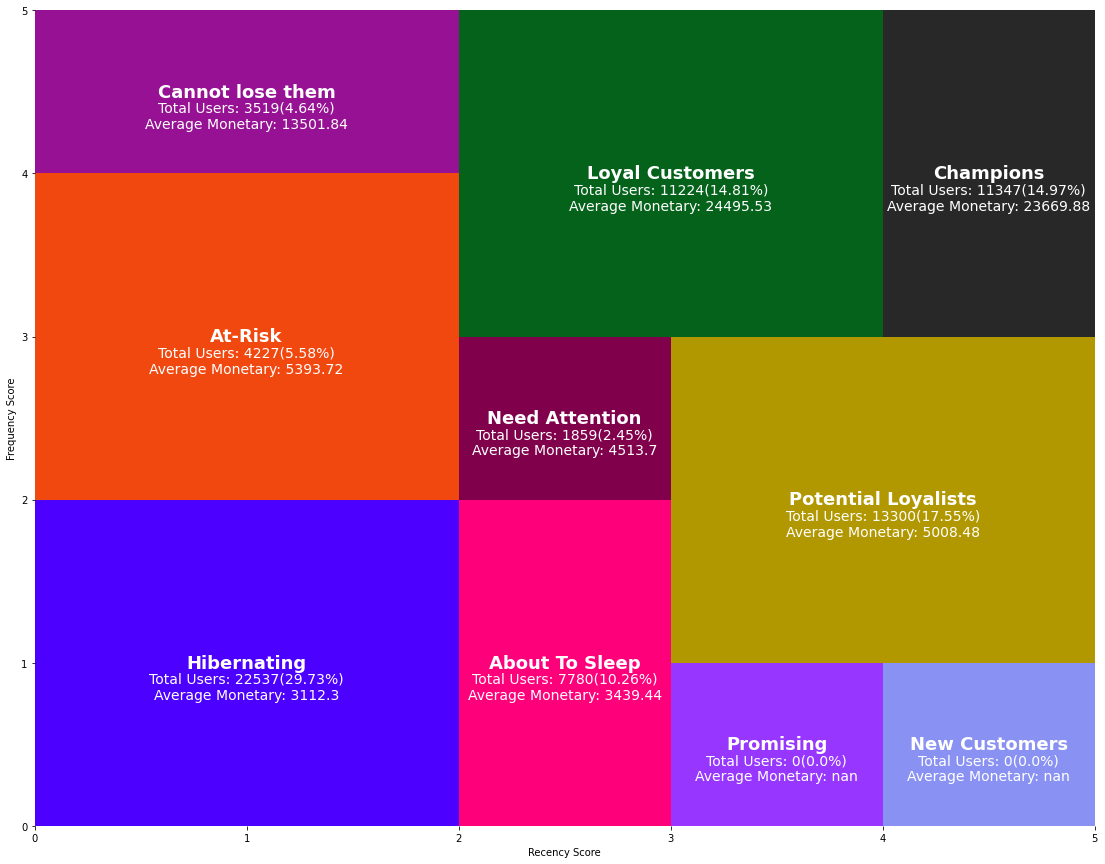

In [25]:
fig, ax = plt.subplots(figsize = (19, 15))

ax.set_xlim([0, 5])
ax.set_ylim([0, 5])

plt.rcParams["axes.facecolor"] = "white"
palette = ["#282828", "#04621B", "#971194", "#F1480F",  "#4C00FF", 
           "#FF007B", "#9736FF", "#8992F3", "#B29800", "#80004C"]

for key, color in zip(rfm_coordinates.keys(), palette[:10]):
    
    coordinates = rfm_coordinates[key]
    ymin, ymax, xmin, xmax = coordinates[0], coordinates[1], coordinates[2], coordinates[3]
    
    ax.axhspan(ymin = ymin, ymax = ymax, xmin = xmin, xmax = xmax, facecolor = color)
    
    users = RFM_abs2[RFM_abs2.Segment == key].shape[0]
    users_percentage = (RFM_abs2[RFM_abs2.Segment == key].shape[0] / RFM_abs2.shape[0]) * 100
    avg_monetary = RFM_abs2[RFM_abs2.Segment == key]["Monetary"].mean()
    
    user_txt = "\n\nTotal Users: " + str(users) + "(" +  str(round(users_percentage, 2)) + "%)"
    monetary_txt = "\n\n\n\nAverage Monetary: " + str(round(avg_monetary, 2))
    
    x = 5 * (xmin + xmax) / 2
    y = (ymin + ymax) / 2
    
    plt.text(x = x, y = y, s = key, ha = "center", va = "center", fontsize = 18, color = "white", fontweight = "bold")
    plt.text(x = x, y = y, s = user_txt, ha = "center", va = "center", fontsize = 14, color = "white")    
    plt.text(x = x, y = y, s = monetary_txt, ha = "center", va = "center", fontsize = 14, color = "white")    
    
    ax.set_xlabel("Recency Score")
    ax.set_ylabel("Frequency Score")
    
sns.despine(left = True, bottom = True)
plt.show()

* Although it had 29.73% hibernating, the sum of loyal customers and champions is 29.75% too. 
* There are potential loyalists with 17.55% of the book.
* Cannot lose them 4.64%
* At risk + About to sleep + Need attention = 18.29%, potential market to boost sales.

In [26]:
# RFM_abs2['discount_rate']
# discount = df_full.groupby()
# Frequency: Total number of purchases
discount = pd.DataFrame(df_full.groupby('Customer ID')['discount_rate'].mean())
print(discount.shape)
print(RFM_abs2)
RFM_abs2_disc =pd.merge(RFM_abs2, discount, on=['Customer ID'], how="left", validate="one_to_one")
RFM_abs2_disc.head()

(113627, 1)
        Customer ID  Recency  Frequency  Monetary R_score F_score M_score  \
0               1.0    788.0          1    1950.0       1       1       3   
7               6.0    788.0          1     170.0       1       1       1   
10              9.0    788.0          1    5500.0       1       1       4   
11             10.0    788.0          1     366.0       1       1       1   
13             11.0    560.0          4     945.0       2       5       2   
...             ...      ...        ...       ...     ...     ...     ...   
584488     110259.0      0.0          1     798.0       5       4       2   
584496     115322.0      0.0          1    1048.0       5       4       2   
584509     115324.0      0.0          1     399.0       5       4       1   
584517     115325.0      0.0          2     899.0       5       5       2   
584519     115320.0      0.0          1     699.0       5       4       1   

       RFM_Segment  RFM_Score           Segment  
0            

Customer ID  Recency  Frequency  Monetary R_score F_score M_score  \
0          1.0    788.0          1    1950.0       1       1       3   
1          6.0    788.0          1     170.0       1       1       1   
2          9.0    788.0          1    5500.0       1       1       4   
3         10.0    788.0          1     366.0       1       1       1   
4         11.0    560.0          4     945.0       2       5       2   

  RFM_Segment  RFM_Score           Segment  discount_rate  
0         113          5       Hibernating            0.0  
1         111          3       Hibernating            0.0  
2         114          6       Hibernating            0.0  
3         111          3       Hibernating            0.0  
4         252          9  Cannot lose them            0.0

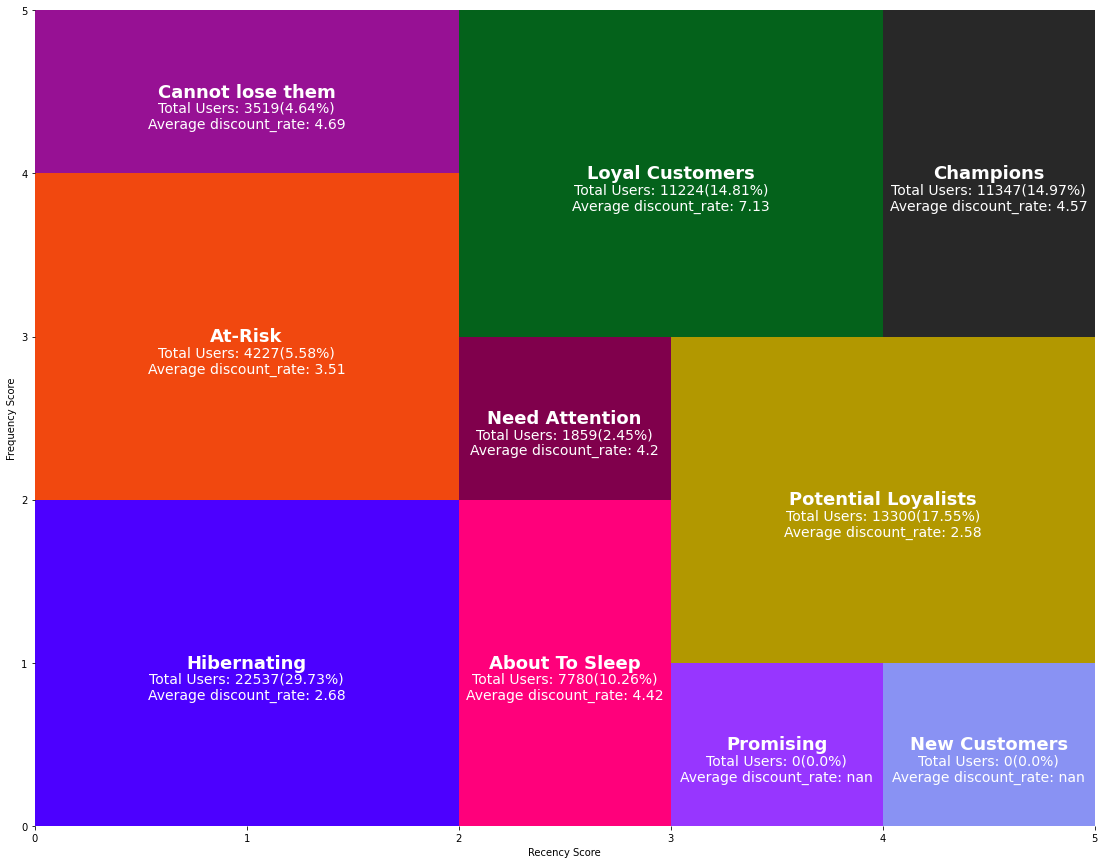

In [27]:
fig, ax = plt.subplots(figsize = (19, 15))

ax.set_xlim([0, 5])
ax.set_ylim([0, 5])

plt.rcParams["axes.facecolor"] = "white"
palette = ["#282828", "#04621B", "#971194", "#F1480F",  "#4C00FF", 
           "#FF007B", "#9736FF", "#8992F3", "#B29800", "#80004C"]

for key, color in zip(rfm_coordinates.keys(), palette[:10]):
    
    coordinates = rfm_coordinates[key]
    ymin, ymax, xmin, xmax = coordinates[0], coordinates[1], coordinates[2], coordinates[3]
    
    ax.axhspan(ymin = ymin, ymax = ymax, xmin = xmin, xmax = xmax, facecolor = color)
    
    users = RFM_abs2_disc[RFM_abs2_disc.Segment == key].shape[0]
    users_percentage = (RFM_abs2_disc[RFM_abs2_disc.Segment == key].shape[0] / RFM_abs2_disc.shape[0]) * 100
    avg_discount_rate = RFM_abs2_disc[RFM_abs2_disc.Segment == key]["discount_rate"].mean()
    
    user_txt = "\n\nTotal Users: " + str(users) + "(" +  str(round(users_percentage, 2)) + "%)"
    discount_rate_txt = "\n\n\n\nAverage discount_rate: " + str(round(avg_discount_rate, 2))
    
    x = 5 * (xmin + xmax) / 2
    y = (ymin + ymax) / 2
    
    plt.text(x = x, y = y, s = key, ha = "center", va = "center", fontsize = 18, color = "white", fontweight = "bold")
    plt.text(x = x, y = y, s = user_txt, ha = "center", va = "center", fontsize = 14, color = "white")    
    plt.text(x = x, y = y, s = discount_rate_txt, ha = "center", va = "center", fontsize = 14, color = "white")    
    
    ax.set_xlabel("Recency Score")
    ax.set_ylabel("Frequency Score")
    
sns.despine(left = True, bottom = True)
plt.show()

Objects:

1.   Loyal customers has similar average monetary as champions, but much higher in discount rate 7.13% vs 4.57%.
>Marketing: Up-sell higher value products & Reward them.

2.   Potential loyalists has the highest number of customers 17.55%. But less than half of the average monetary in
>Marketing: Recommend other products. Engage in loyalty programs.

3.   Tiny new customers & promising
>Markeing: Provide a good onboarding process &  Create more brand awareness. 

4. Cannot lose them & about to sleep & need attention & at risk offerred similar discount level between 3% to 4.5%.
>Marketing: Reactivate them & special offer

5. Large proportion of hibernating, very high average monetary, but low in discount rate.
>Offer relevant products and good offers




In [28]:
RFM_abs3 = RFM_abs2.reset_index()

rfm_monetary_size = RFM_abs3.groupby("Segment").agg({"Monetary": "mean",
                                                       "Customer ID": "nunique"})

rfm_monetary_size.rename(columns = {"Monetary": "MeanMonetary", "Customer ID": "CustomerCount"}, inplace = True)
rfm_monetary_size = rfm_monetary_size.sort_values("MeanMonetary", ascending = False)

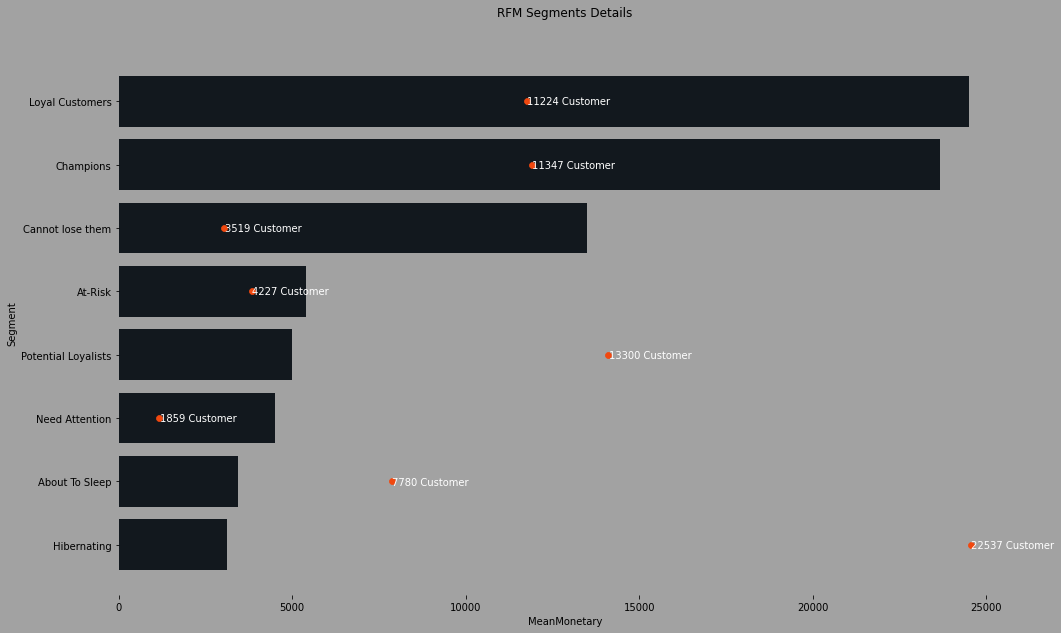

In [29]:
plt.rcParams["axes.facecolor"] = "#A2A2A2"
fig, ax = plt.subplots(figsize = (16, 10), facecolor = "#A2A2A2")

sns.barplot(x = rfm_monetary_size.MeanMonetary, y = rfm_monetary_size.index, ax = ax, color = "#101820")
ax2 = ax.twiny()
sns.lineplot(x = rfm_monetary_size.CustomerCount, y = rfm_monetary_size.index, ax = ax2, marker = "o", linewidth = 0,
             color = "#F1480F", markeredgecolor = "#F1480F")


ax2.axis("off")

for y, x in list(enumerate(rfm_monetary_size.CustomerCount)):
    ax2.text(x + 10, y + 0.05, str(x) + " Customer", color = "white", fontweight = "normal")

plt.title("RFM Segments Details")
sns.despine(left = True, right = True, bottom = True, top = True)
plt.show()

Object:


*   Sorted by number of customers (black bars).
*   Red dots are average monetary.



In [30]:
RFM_abs3['Score'] = 'Green'
RFM_abs3.loc[RFM_abs3['RFM_Score']>5,'Score'] = 'Bronze' 
RFM_abs3.loc[RFM_abs3['RFM_Score']>7,'Score'] = 'Silver' 
RFM_abs3.loc[RFM_abs3['RFM_Score']>9,'Score'] = 'Gold' 
RFM_abs3.loc[RFM_abs3['RFM_Score']>10,'Score'] = 'Platinum'

RFM_abs3.head(5)

index  Customer ID  Recency  Frequency  Monetary R_score F_score M_score  \
0      0          1.0    788.0          1    1950.0       1       1       3   
1      7          6.0    788.0          1     170.0       1       1       1   
2     10          9.0    788.0          1    5500.0       1       1       4   
3     11         10.0    788.0          1     366.0       1       1       1   
4     13         11.0    560.0          4     945.0       2       5       2   

  RFM_Segment  RFM_Score           Segment   Score  
0         113          5       Hibernating   Green  
1         111          3       Hibernating   Green  
2         114          6       Hibernating  Bronze  
3         111          3       Hibernating   Green  
4         252          9  Cannot lose them  Silver

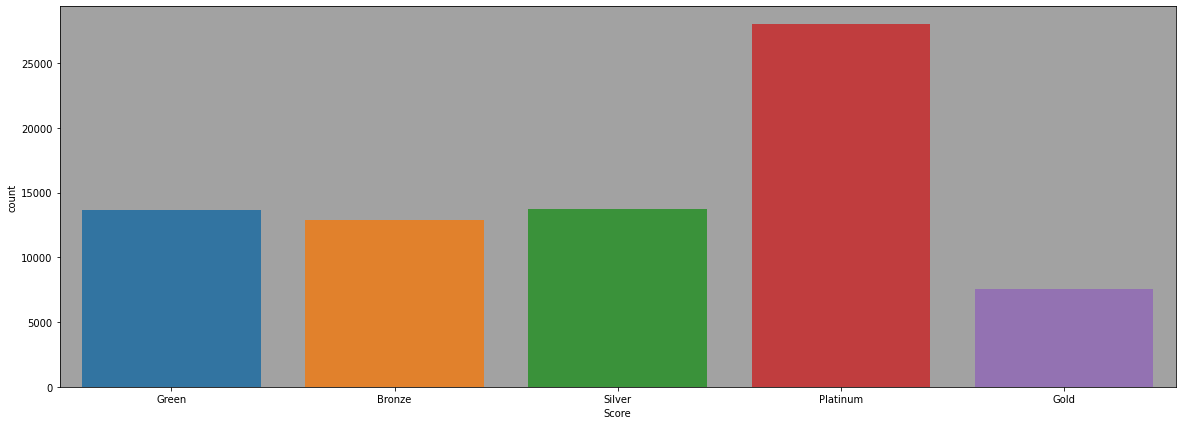

In [31]:
plt.figure(figsize=(20,7))
sns.countplot(x = RFM_abs3.Score);



---
# *Improved model vs customer segments*
Link to cell of improved model:
https://colab.research.google.com/drive/181gD0Hnl79jwTeHqGGBidRjR6bk2AaXu#scrollTo=XjmPoqW_ivv5&line=7&uniqifier=1

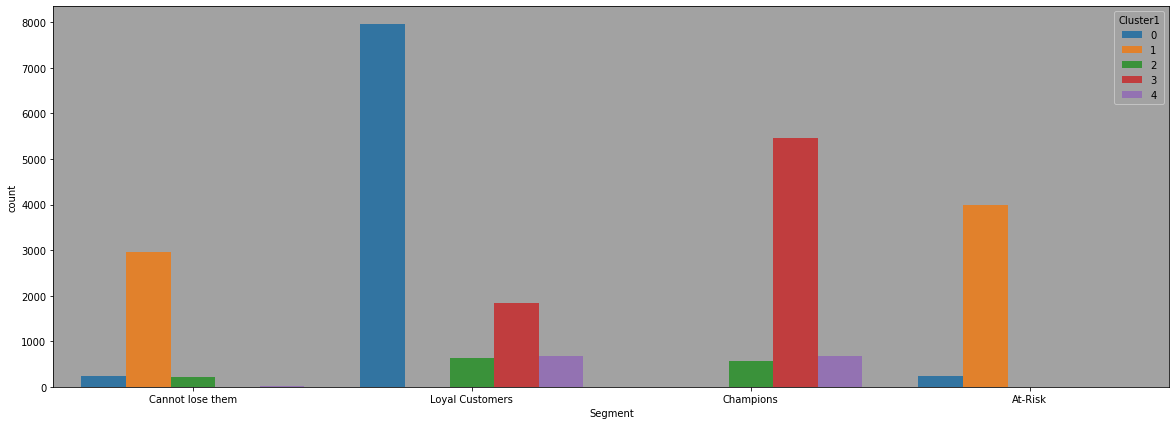

In [38]:
# RFM_res2 = RFM_abs3.copy()
RFM_res2 = RFM_abs3[(RFM_abs3["Frequency"]!=1)&(RFM_abs3["Monetary"]<=250000)&(RFM_abs3["Frequency"]<=20)]
RFM_res2['Cluster1'] = kmeans.labels_
RFM_res2.head()

plt.figure(figsize=(20,7))
sns.countplot(x = RFM_res2.Segment, hue = RFM_res2.Cluster1);

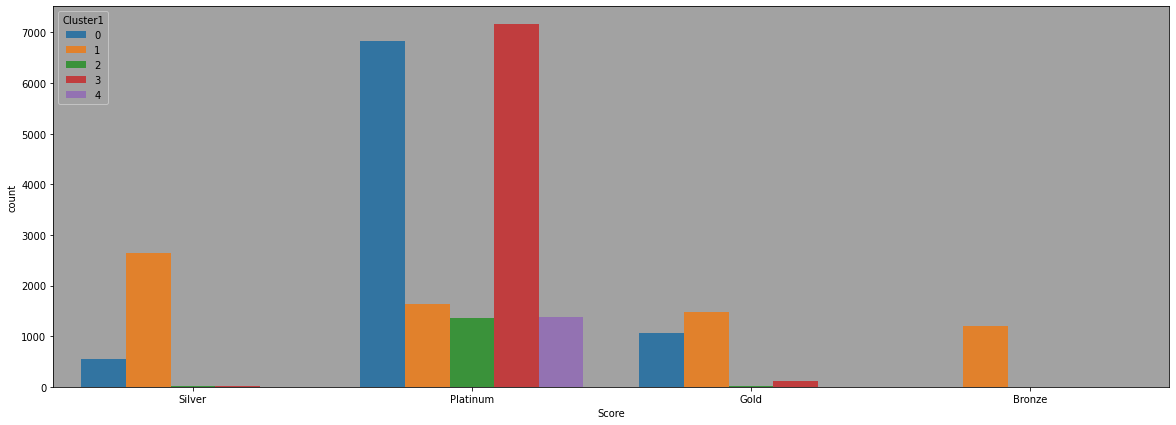

In [39]:
plt.figure(figsize=(20,7))
sns.countplot(x = RFM_res2.Score, hue = RFM_res2.Cluster1);

Object:


*   The improved model was built based on sample reduction. But this left only 4 customer segments.




---

# **Base model vs customer segments**
Linkd to cell related to base model
https://colab.research.google.com/drive/181gD0Hnl79jwTeHqGGBidRjR6bk2AaXu#scrollTo=fYyXnRhJMmQT&line=4&uniqifier=1

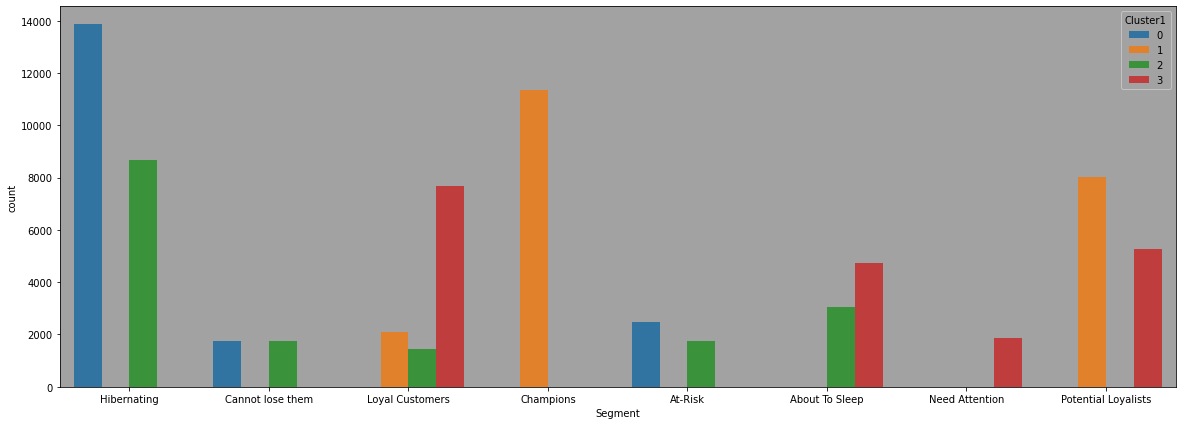

In [60]:
RFM_res2 = RFM_abs3.copy()
# RFM_res2 = RFM_abs3[(RFM_abs3["Frequency"]!=1)&(RFM_abs3["Monetary"]<=250000)&(RFM_abs3["Frequency"]<=20)]
RFM_res2['Cluster1'] = kmeans.labels_
RFM_res2.head()

plt.figure(figsize=(20,7))
sns.countplot(x = RFM_res2.Segment, hue = RFM_res2.Cluster1);

Cluster 0: Hibernating (2/3) + cannot lose them (1/2) + At-Risk (1/2);
>  Reactivate them & special offer;

Cluster 1: Champions all + potential loyalities (more than half) + Loyal customers (1/5);
> Offer higher discount rates;

Cluster 2: Hibernating (1/3) + Cannnot lose them (half) + At-Risk (half) + About to Sleep (half) + loyal customers;
> Offer relevant products and good offers

Cluster 3: Loyal customers (majority) + potential loyalists (half) + Need attention all + About to sleep;
> Reward them and recommend other products;


In [61]:
# Average RFM values per cluster
RFM_res2.groupby(['Cluster1']).agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean','count']
}).round(0)

Recency Frequency Monetary       
            mean      mean     mean  count
Cluster1                                  
0          653.0       2.0   3805.0  18092
1          126.0       3.0  18838.0  21485
2          465.0       2.0   5574.0  16689
3          283.0       2.0  11223.0  19527

mean frequency is too high?

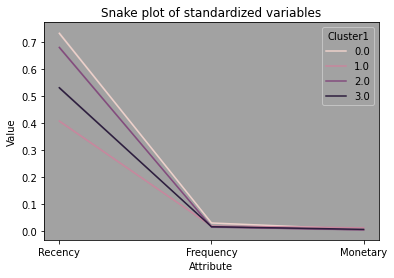

In [163]:
# Snake plot
RFM = pd.DataFrame(RFM,
                   index=RFM_res2['Customer ID'],
                   columns=['Recency', 'Frequency', 'Monetary'])

RFM['Cluster1'] = RFM_res2['Cluster1']

RFM_melt = pd.melt(RFM.reset_index(),
                   id_vars=['Customer ID', 'Cluster1'],
                   value_vars=['Recency', 'Frequency', 'Monetary'],
                   var_name='Attribute',
                   value_name='Value')

plt.title('Snake plot of standardized variables')
sns.lineplot(x='Attribute', y='Value', hue='Cluster1', data=RFM_melt);

In [63]:
# Relative importance of segment
cluster_avg = RFM_res.drop('Customer ID', axis=1).groupby(['Cluster1']).mean()
population_avg = RFM_abs.drop('Customer ID', axis=1).mean()
relative_imp = cluster_avg / population_avg -1

relative_imp.round(2)

Recency  Frequency  Monetary
Cluster1                              
0            0.78      -0.27     -0.63
1           -0.66       0.28      0.82
2            0.27      -0.11     -0.46
3           -0.23       0.04      0.08

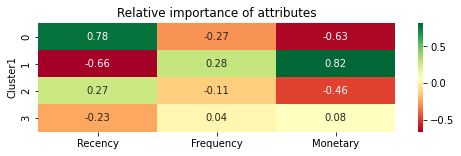

In [64]:
plt.figure(figsize=(8,2))
plt.title('Relative importance of attributes')
sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap='RdYlGn')
plt.show();

# RFM Skewness analysis and new model test 

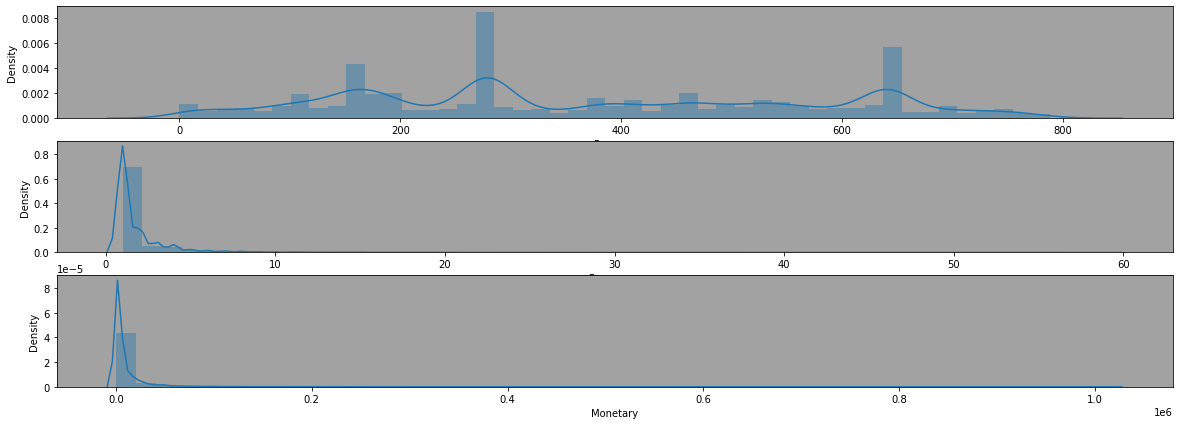

In [65]:
# distributions of RFM
plt.figure(figsize=(20,7))
plt.subplot(3, 1, 1); sns.distplot(RFM_abs['Recency'])
plt.subplot(3, 1, 2); sns.distplot(RFM_abs['Frequency'])
plt.subplot(3, 1, 3); sns.distplot(RFM_abs['Monetary'])
plt.show();

Object: Frequency and Monetary are positive skewness.

In [141]:
# Recency min value = 0, reset it to 1, otherwise there will be infinite after log.
RFM_abs['Recency'] = RFM_abs['Recency'] + 1
RFM_abs.head()

Customer ID  Recency  Frequency  Monetary
0           1.0    790.0          1    1950.0
7           6.0    790.0          1     170.0
10          9.0    790.0          1    5500.0
11         10.0    790.0          1     366.0
13         11.0    562.0          4     945.0

In [142]:
RFM_log = np.log(RFM_abs.drop('Customer ID', axis=1))
RFM_log.head()

Recency  Frequency  Monetary
0   6.672033   0.000000  7.575585
7   6.672033   0.000000  5.135798
10  6.672033   0.000000  8.612503
11  6.672033   0.000000  5.902633
13  6.331502   1.386294  6.851185

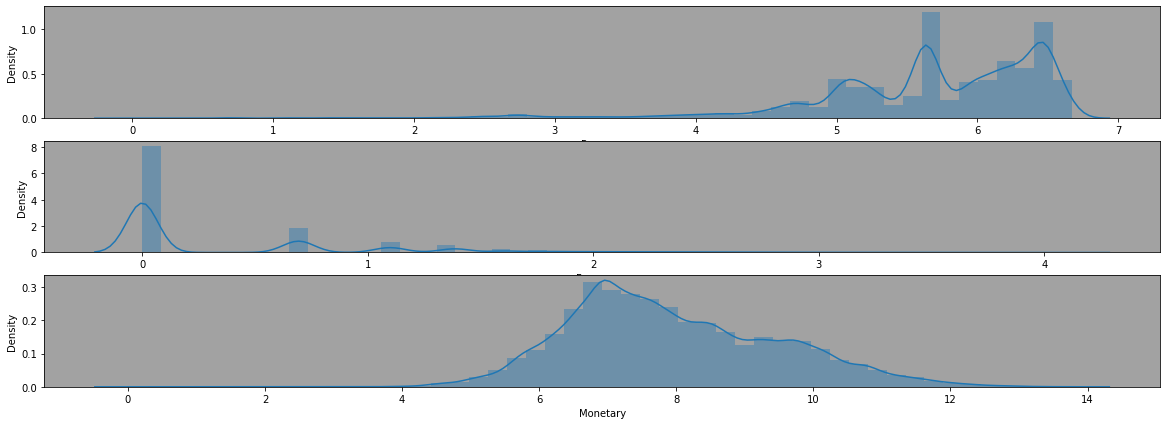

In [140]:
# distributions of RFM
plt.figure(figsize=(20,7))
plt.subplot(3, 1, 1); sns.distplot(RFM_abs_log['Recency'])
plt.subplot(3, 1, 2); sns.distplot(RFM_abs_log['Frequency'])
plt.subplot(3, 1, 3); sns.distplot(RFM_abs_log['Monetary'])
plt.show();

Object: More symmetric now.

In [143]:
# Standardise
# scaler=preprocessing.MinMaxScaler().fit(RFM_log)
scaler=preprocessing.StandardScaler()
scaler.fit(RFM_log)
RFM_normalized=scaler.transform(RFM_log)

In [144]:
# number of clusters
range_n_cluster = [2,3,4,5,6,7,8,9,10,11,12]
ssd = []
distortions = []
for i in range_n_cluster:
    kmeans_log = KMeans(n_clusters = i, random_state=seed)
    kmeans_log.fit(RFM_normalized)
    ssd.append(kmeans_log.inertia_)
    distortions.append(sum(np.min(cdist(RFM_normalized, kmeans_log.cluster_centers_, 'euclidean'), axis=1)) / np.size(RFM_normalized, axis = 0))

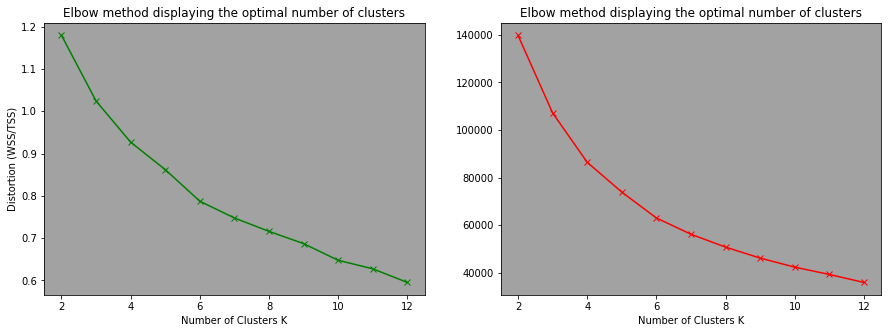

In [145]:
# Plotting the distortion as a function of the number of clusters
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(range_n_cluster, distortions, 'gx-')
plt.xlabel('Number of Clusters K')
plt.ylabel('Distortion (WSS/TSS)')
plt.title('Elbow method displaying the optimal number of clusters');

plt.subplot(1,2,2)
plt.plot(range_n_cluster, ssd, 'rx-')
plt.xlabel('Number of Clusters K')
plt.title('Elbow method displaying the optimal number of clusters');

In [158]:
# best number of clusters = 3
kmeans_log = KMeans(n_clusters = 3, random_state=seed)
kmeans_log.fit(RFM_normalized)
silhouette_score(RFM_normalized,kmeans_log.labels_,metric="sqeuclidean")

0.4971442972446501

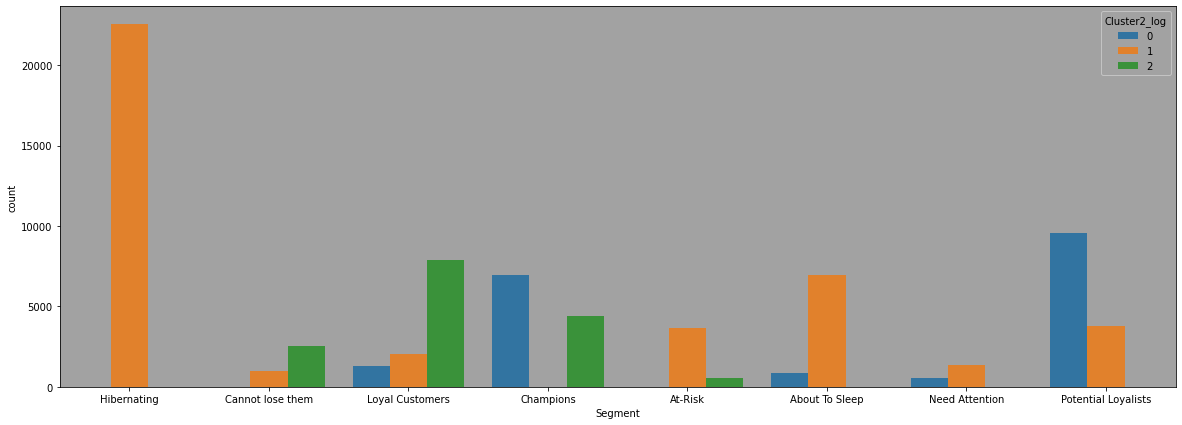

In [159]:

RFM_res2['Cluster2_log'] = kmeans_log.labels_
RFM_res2.head()

plt.figure(figsize=(20,7))
sns.countplot(x = RFM_res2.Segment, hue = RFM_res2.Cluster2_log);

Cluster 0: Potential Loyalists 2/3 + Champions 2/3 + Loyal Customers 1/5 + Need Attention (little) 
> Marketing: Offer higher discount rates;

Cluster 1: Dominated by hibemating + about to sleep (majority)
> Marketing: Offer relevant products and good offers

Cluster 2: Loyal Customers + Champions + Cannot lose them + at risk (little)
> Marketing: Reward them and recommend other products;


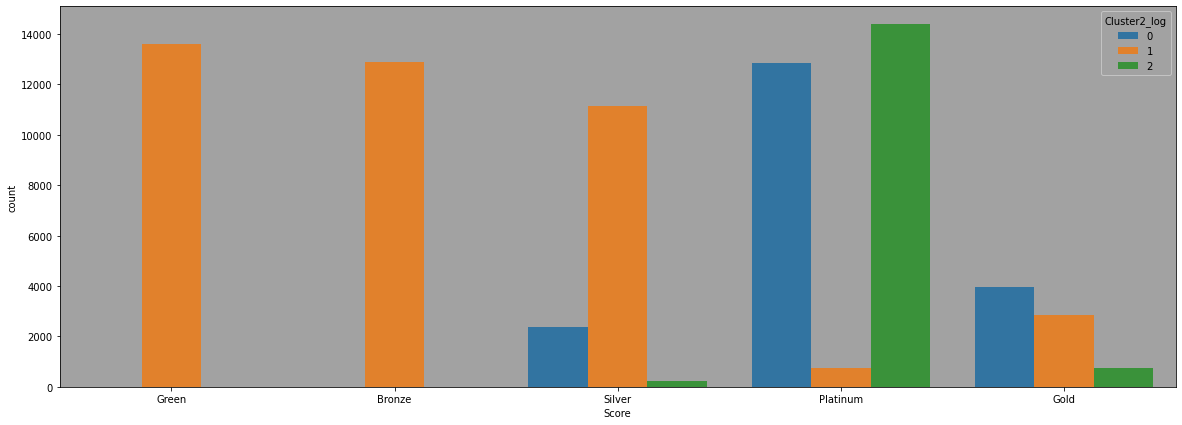

In [160]:
plt.figure(figsize=(20,7))
sns.countplot(x = RFM_res2.Score, hue = RFM_res2.Cluster2_log);

Cluster 0:
> Marketing: Offer higher discount rates;
>
Cluster 1:
> All green and brone and majority silver. Offer relevant products and good offers.
>
Cluster 2:
> Top sellers: Reward them and recommend other products;

In [161]:
# Average RFM values per cluster
RFM_res2.groupby(['Cluster2_log']).agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean','count']
}).round(0)

Recency Frequency Monetary       
                mean      mean     mean  count
Cluster2_log                                  
0              156.0       1.0   6171.0  19166
1              498.0       1.0   2589.0  41257
2              279.0       6.0  36477.0  15370

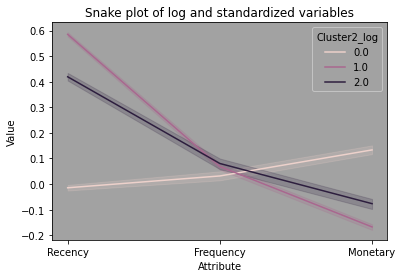

In [164]:
# Snake plot
RFM_normalized = pd.DataFrame(RFM_normalized,
                              index=RFM_res2['Customer ID'],
                              columns=RFM_log.columns)

RFM_normalized['Cluster2_log'] = RFM_res2['Cluster2_log']

RFM_melt = pd.melt(RFM_normalized.reset_index(),
                   id_vars=['Customer ID', 'Cluster2_log'],
                   value_vars=['Recency', 'Frequency', 'Monetary'],
                   var_name='Attribute',
                   value_name='Value')

plt.title('Snake plot of log and standardized variables')
sns.lineplot(x='Attribute', y='Value', hue='Cluster2_log', data=RFM_melt);

Objective: Significant different clusters.

In [177]:
# Relative importance of segment
cluster_avg = RFM_res2.loc[:,('Recency',	'Frequency',	'Monetary',	'Cluster2_log')].groupby(['Cluster2_log']).mean()
population_avg = RFM_abs.drop('Customer ID', axis=1).mean()
relative_imp = cluster_avg / population_avg -1

relative_imp.round(2)

Recency  Frequency  Monetary
Cluster2_log                              
0               -0.58      -0.41     -0.40
1                0.35      -0.43     -0.75
2               -0.24       1.65      2.52

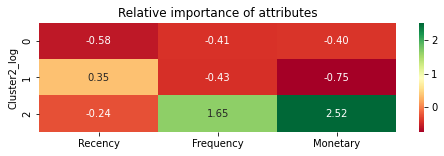

In [178]:
plt.figure(figsize=(8,2))
plt.title('Relative importance of attributes')
sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap='RdYlGn')
plt.show();

# RMF + Lifetime value


In [181]:
#RFM table
RFM_abs= data[['Customer ID', 'Recency', 'Frequency', 'Monetary', 'Lifetime']].drop_duplicates()
RFM_abs['Recency'] = RFM_abs['Recency'] + 1
print(RFM_abs.shape)
RFM_abs.head()

(75793, 5)


Customer ID  Recency  Frequency  Monetary  Lifetime
0           1.0    789.0          1    1950.0     789.0
7           6.0    789.0          1     170.0     789.0
10          9.0    789.0          1    5500.0     789.0
11         10.0    789.0          1     366.0     789.0
13         11.0    561.0          4     945.0     789.0

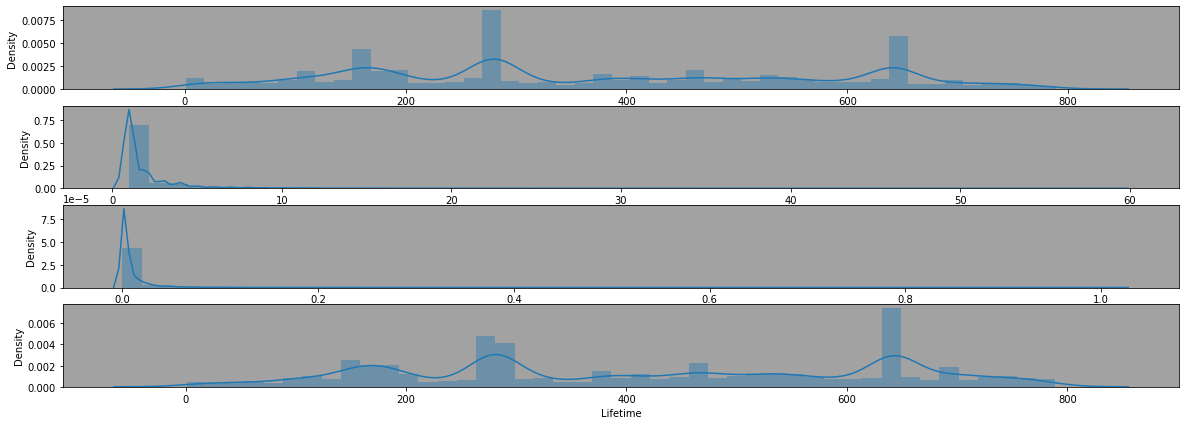

In [183]:
# distributions of RFM
plt.figure(figsize=(20,7))
plt.subplot(4, 1, 1); sns.distplot(RFM_abs['Recency'])
plt.subplot(4, 1, 2); sns.distplot(RFM_abs['Frequency'])
plt.subplot(4, 1, 3); sns.distplot(RFM_abs['Monetary'])
plt.subplot(4, 1, 4); sns.distplot(RFM_abs['Lifetime'])
plt.show();

In [185]:
RFM_log = np.log(RFM_abs.drop('Customer ID', axis=1))
RFM_log.head()

Recency  Frequency  Monetary  Lifetime
0   6.670766   0.000000  7.575585  6.670766
7   6.670766   0.000000  5.135798  6.670766
10  6.670766   0.000000  8.612503  6.670766
11  6.670766   0.000000  5.902633  6.670766
13  6.329721   1.386294  6.851185  6.670766

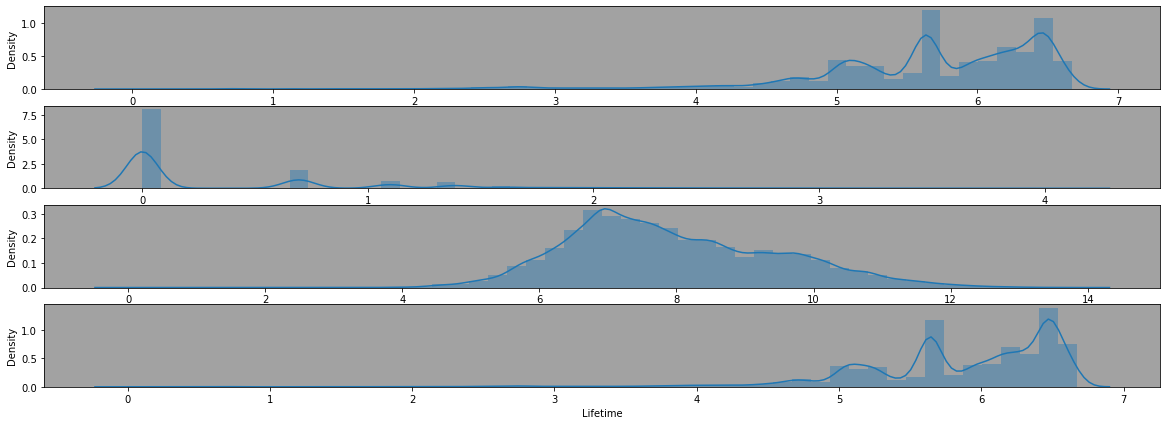

In [186]:
# distributions of RFM
plt.figure(figsize=(20,7))
plt.subplot(4, 1, 1); sns.distplot(RFM_log['Recency'])
plt.subplot(4, 1, 2); sns.distplot(RFM_log['Frequency'])
plt.subplot(4, 1, 3); sns.distplot(RFM_log['Monetary'])
plt.subplot(4, 1, 4); sns.distplot(RFM_log['Lifetime'])
plt.show();

In [187]:
# Standardise
# scaler=preprocessing.MinMaxScaler().fit(RFM_log)
scaler=preprocessing.StandardScaler()
scaler.fit(RFM_log)
RFM_normalized=scaler.transform(RFM_log)

In [188]:
# number of clusters
range_n_cluster = [2,3,4,5,6,7,8,9,10,11,12]
ssd = []
distortions = []
for i in range_n_cluster:
    kmeans_log = KMeans(n_clusters = i, random_state=seed)
    kmeans_log.fit(RFM_normalized)
    ssd.append(kmeans_log.inertia_)
    distortions.append(sum(np.min(cdist(RFM_normalized, kmeans_log.cluster_centers_, 'euclidean'), axis=1)) / np.size(RFM_normalized, axis = 0))

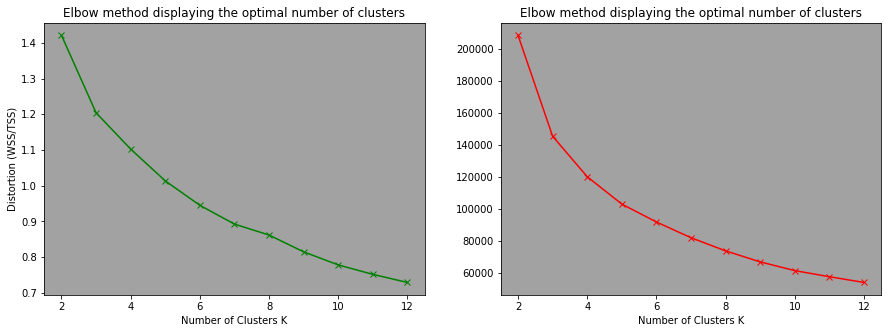

In [189]:
# Plotting the distortion as a function of the number of clusters
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(range_n_cluster, distortions, 'gx-')
plt.xlabel('Number of Clusters K')
plt.ylabel('Distortion (WSS/TSS)')
plt.title('Elbow method displaying the optimal number of clusters');

plt.subplot(1,2,2)
plt.plot(range_n_cluster, ssd, 'rx-')
plt.xlabel('Number of Clusters K')
plt.title('Elbow method displaying the optimal number of clusters');

In [194]:
# best number of clusters = 3
kmeans_log = KMeans(n_clusters = 3, random_state=seed)
kmeans_log.fit(RFM_normalized)
silhouette_score(RFM_normalized,kmeans_log.labels_,metric="sqeuclidean")

0.5611404236350782

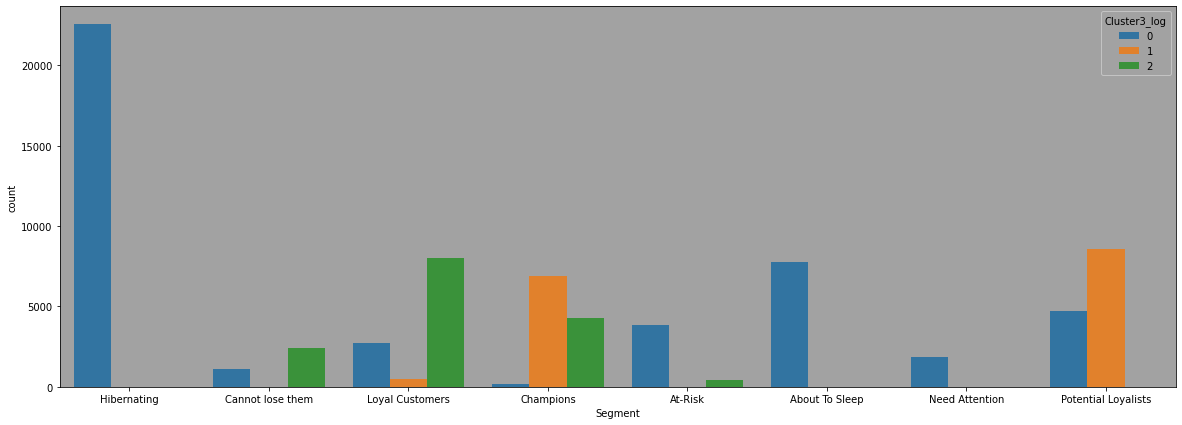

In [195]:
RFM_res2['Cluster3_log'] = kmeans_log.labels_
RFM_res2.head()

plt.figure(figsize=(20,7))
sns.countplot(x = RFM_res2.Segment, hue = RFM_res2.Cluster3_log);

Cluster 0: Dominated by Hibermating + About to Sleep + Need attention + At Risk
>
Cluster 1: Champions + Potential Loyalists
>
Cluster 2: Loyal customers + Champioins (near half) + Cannot lose them (more than half)

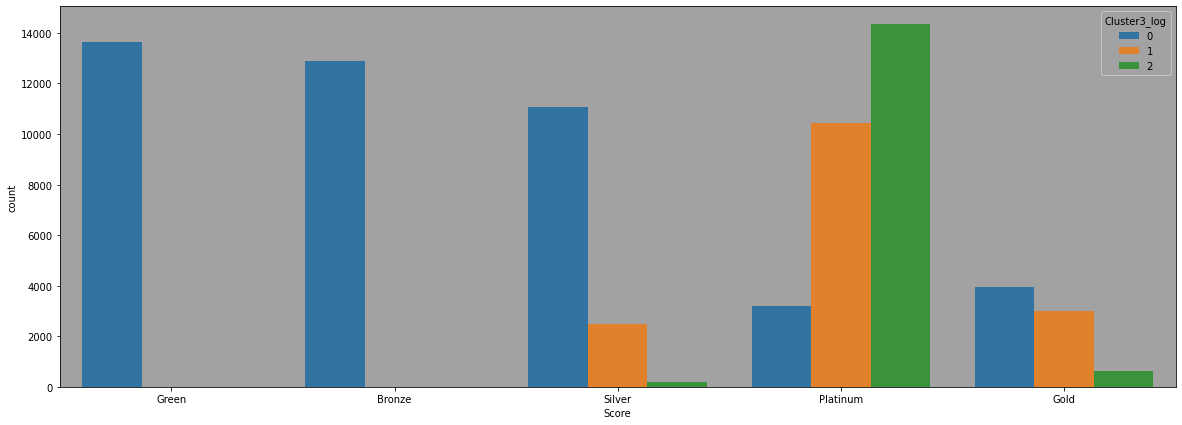

In [196]:
plt.figure(figsize=(20,7))
sns.countplot(x = RFM_res2.Score, hue = RFM_res2.Cluster3_log);

In [199]:
# Average RFM values per cluster
RFM_res2['Lifetime'] = RFM_abs['Lifetime']
RFM_res2.groupby(['Cluster3_log']).agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean','count'],
    'Lifetime': 'mean'
}).round(0)

Recency Frequency Monetary        Lifetime
                mean      mean     mean  count     mean
Cluster3_log                                           
0              483.0       1.0   3243.0  44742    718.0
1              131.0       1.0   5690.0  15904    650.0
2              274.0       6.0  36322.0  15147    709.0

Models' average comparison:
>
https://colab.research.google.com/drive/181gD0Hnl79jwTeHqGGBidRjR6bk2AaXu#scrollTo=jGftC-q-2fpU&line=1&uniqifier=1

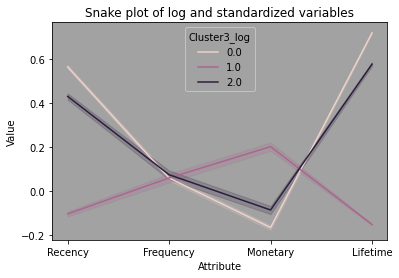

In [203]:
# Snake plot
RFM_normalized = pd.DataFrame(RFM_normalized,
                              index=RFM_res2['Customer ID'],
                              columns=RFM_log.columns)

RFM_normalized['Cluster3_log'] = RFM_res2['Cluster3_log']

RFM_melt = pd.melt(RFM_normalized.reset_index(),
                   id_vars=['Customer ID', 'Cluster3_log'],
                   value_vars=['Recency', 'Frequency', 'Monetary', 'Lifetime'],
                   var_name='Attribute',
                   value_name='Value')

plt.title('Snake plot of log and standardized variables')
sns.lineplot(x='Attribute', y='Value', hue='Cluster3_log', data=RFM_melt);

Object: Monetary do not significantly different, instead lifetime is significantly different.

In [204]:
# Relative importance of segment
cluster_avg = RFM_res2.loc[:,('Recency',	'Frequency',	'Monetary',	'Lifetime', 'Cluster3_log')].groupby(['Cluster3_log']).mean()
population_avg = RFM_abs.drop('Customer ID', axis=1).mean()
relative_imp = cluster_avg / population_avg -1

relative_imp.round(2)

Recency  Frequency  Monetary  Lifetime
Cluster3_log                                        
0                0.31      -0.42     -0.69      0.73
1               -0.64      -0.40     -0.45      0.56
2               -0.26       1.66      2.50      0.70

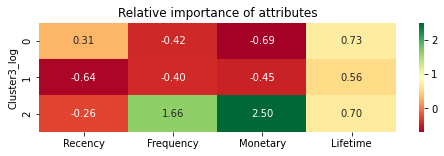

In [205]:
plt.figure(figsize=(8,2))
plt.title('Relative importance of attributes')
sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap='RdYlGn')
plt.show();

# Predict complete and cancel
To predict complete and cancel using 


1.   Recency, Frequency, Monetary 3 features
2.   RMF log model with combination of 3 features
3.   RMF + Lifetime clusters

TBC: data per invoice basis
TBC: All canceled status, RMF and lifetime values are 0?!

In [265]:
data=df_full[(df_full["status_new"]=="completed")|(df_full["status_new"]=="canceled")]
print(data.shape)
data = data[(data['grand_item'] > 0)]
print(data.shape)

(422441, 28)
(422441, 28)


In [266]:
data_group=data.groupby(["increment_id", 'Customer ID', 'status_new']).agg({"grand_item":"sum",
                                                              "discount_rate":"mean",
                                                              "item_id":"count", 
                                                              "Lifetime":"mean"
})
print(data_group.shape)
data_group.head()

(308601, 4)


grand_item  discount_rate  item_id  \
increment_id Customer ID status_new                                       
100001290    19328.0     completed      332.000           0.00        1   
100147443    1.0         completed     1950.000           0.00        1   
100147444    2.0         canceled       240.000           0.00        1   
100147445    3.0         canceled      2450.000           0.00        1   
100147446    4.0         completed       60.012          83.33        1   

                                     Lifetime  
increment_id Customer ID status_new            
100001290    19328.0     completed      644.0  
100147443    1.0         completed      789.0  
100147444    2.0         canceled       789.0  
100147445    3.0         canceled       789.0  
100147446    4.0         completed      789.0

In [267]:
RFM_to_join = RFM_res2.loc[:, ('Recency', 'Frequency', 'Monetary',
                               'Cluster1', 'Cluster2_log', 'Cluster3_log', 'Customer ID'
)]
RFM_to_join['status_new'] = 'completed'
print(RFM_to_join.shape)
RFM_to_join.head()                             

(75793, 8)


Recency  Frequency  Monetary  Cluster1  Cluster2_log  Cluster3_log  \
0    788.0          1    1950.0         0             1             0   
1    788.0          1     170.0         0             1             0   
2    788.0          1    5500.0         0             1             0   
3    788.0          1     366.0         0             1             0   
4    560.0          4     945.0         2             1             0   

   Customer ID status_new  
0          1.0  completed  
1          6.0  completed  
2          9.0  completed  
3         10.0  completed  
4         11.0  completed

In [275]:
data2=pd.merge(data_group, RFM_to_join, on=['Customer ID', 'status_new'], how="left", validate="many_to_one")
data2 = data2.fillna(0)
print(data2.shape)
data2.head()

(308601, 12)


Customer ID status_new  grand_item  discount_rate  item_id  Lifetime  \
0      19328.0  completed     332.000           0.00        1     644.0   
1          1.0  completed    1950.000           0.00        1     789.0   
2          2.0   canceled     240.000           0.00        1     789.0   
3          3.0   canceled    2450.000           0.00        1     789.0   
4          4.0  completed      60.012          83.33        1     789.0   

   Recency  Frequency  Monetary  Cluster1  Cluster2_log  Cluster3_log  
0    643.0        1.0     332.0       0.0           1.0           0.0  
1    788.0        1.0    1950.0       0.0           1.0           0.0  
2      0.0        0.0       0.0       0.0           0.0           0.0  
3      0.0        0.0       0.0       0.0           0.0           0.0  
4      0.0        0.0       0.0       0.0           0.0           0.0

In [276]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [277]:
X, y = data2.drop(['Customer ID', 'status_new'], axis=1), data2.status_new

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = seed)


In [278]:
X_train_copy = X_train.copy()
X_test_copy = X_test.copy()

In [279]:
# Recency, Frequency, Monetary 3 features

X_train = X_train_copy.drop(['Cluster1',	'Cluster2_log',	'Cluster3_log'], axis=1)
X_test = X_test_copy.drop(['Cluster1',	'Cluster2_log',	'Cluster3_log'], axis=1)

clf = linear_model.LogisticRegression(C=1.0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print( classification_report(y_test, y_pred) )

confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual class'], colnames=['Predicted class'])
confusion_matrix

              precision    recall  f1-score   support

    canceled       0.88      0.99      0.93     29025
   completed       0.99      0.89      0.93     32696

    accuracy                           0.93     61721
   macro avg       0.94      0.94      0.93     61721
weighted avg       0.94      0.93      0.93     61721



Predicted class  canceled  completed
Actual class                        
canceled            28709        316
completed            3735      28961

In [281]:
# RMF base model with combination of 3 features

X_train = X_train_copy.drop(['Cluster2_log',	'Cluster3_log', 'Recency',	'Frequency', 'Monetary'], axis=1)
X_test = X_test_copy.drop(['Cluster2_log',	'Cluster3_log', 'Recency',	'Frequency', 'Monetary'], axis=1)

clf = linear_model.LogisticRegression(C=1.0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print( classification_report(y_test, y_pred) )

confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual class'], colnames=['Predicted class'])
confusion_matrix

              precision    recall  f1-score   support

    canceled       0.83      0.89      0.86     29025
   completed       0.89      0.84      0.87     32696

    accuracy                           0.86     61721
   macro avg       0.86      0.86      0.86     61721
weighted avg       0.86      0.86      0.86     61721



Predicted class  canceled  completed
Actual class                        
canceled            25731       3294
completed            5249      27447

In [282]:
# RMF log model with combination of 3 features

X_train = X_train_copy.drop(['Cluster1',	'Cluster3_log', 'Recency',	'Frequency', 'Monetary'], axis=1)
X_test = X_test_copy.drop(['Cluster1',	'Cluster3_log', 'Recency',	'Frequency', 'Monetary'], axis=1)

clf = linear_model.LogisticRegression(C=1.0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print( classification_report(y_test, y_pred) )

confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual class'], colnames=['Predicted class'])
confusion_matrix

              precision    recall  f1-score   support

    canceled       0.76      1.00      0.86     29025
   completed       1.00      0.72      0.84     32696

    accuracy                           0.85     61721
   macro avg       0.88      0.86      0.85     61721
weighted avg       0.89      0.85      0.85     61721



Predicted class  canceled  completed
Actual class                        
canceled            29025          0
completed            9063      23633

In [283]:
# RMF log + lifetime model with combination of 3 features

X_train = X_train_copy.drop(['Cluster1',	'Cluster2_log', 'Recency',	'Frequency', 'Monetary'], axis=1)
X_test = X_test_copy.drop(['Cluster1',	'Cluster2_log', 'Recency',	'Frequency', 'Monetary'], axis=1)

clf = linear_model.LogisticRegression(C=1.0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print( classification_report(y_test, y_pred) )

confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual class'], colnames=['Predicted class'])
confusion_matrix

              precision    recall  f1-score   support

    canceled       0.76      0.82      0.79     29025
   completed       0.83      0.77      0.80     32696

    accuracy                           0.80     61721
   macro avg       0.80      0.80      0.80     61721
weighted avg       0.80      0.80      0.80     61721



Predicted class  canceled  completed
Actual class                        
canceled            23941       5084
completed            7488      25208



---

